<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone Project: Predicting Sepsis

# Introduction to Project

## Problem Statement:
To identify whether a person has sepsis based on early physiological factors provided such as vital signs (pulse oximetry, systolic/ diastolic blood pressure), lab values and demographics provided

The goal of the analysis is the early detection of sepsis using physiological data.

The early prediction of sepsis is potentially life-saving, and we aim to predict sepsis n hours before the clinical prediction.

Late prediction of sepsis is potentially life-threatening, and also consumes heavy hospital resources.

By predicting sepsis in non-sepsis patients or predicting sepsis very early in sepsis patients consumes limited resources and we can assume the risk of prediction to be minimal.

## Libraries

In [1]:
#Run this cell if first time installing pycaret
#!pip install --pre pycaret

In [2]:
# importing necessary libraries
import os
import math
import pycaret
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [4]:
from pycaret.classification import *

# Loading the Datasets

In [14]:
# loading the dataset from csv
path = 'C:/Users/gohch/Documents/GA/Capstone/'
df_full = pd.read_csv(path+ 'Dataset/Dataset.csv', index_col = [0])
df = df_full


In [190]:
df_full.to_pickle('Dataset.pickle')

In [8]:
df_full = pd.read_pickle('Dataset.pickle')#, index_col = [0])
df = df_full

In [9]:
df.head()

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,1,0,17072
1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,2,0,17072
2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,3,0,17072
3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,4,0,17072
4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,NaN,NaN,...,NaN,330.0,68.54,0,NaN,NaN,-0.02,5,0,17072


In [10]:
df.dtypes

Hour                  int64
HR                  float64
O2Sat               float64
Temp                float64
SBP                 float64
MAP                 float64
DBP                 float64
Resp                float64
EtCO2               float64
BaseExcess          float64
HCO3                float64
FiO2                float64
pH                  float64
PaCO2               float64
SaO2                float64
AST                 float64
BUN                 float64
Alkalinephos        float64
Calcium             float64
Chloride            float64
Creatinine          float64
Bilirubin_direct    float64
Glucose             float64
Lactate             float64
Magnesium           float64
Phosphate           float64
Potassium           float64
Bilirubin_total     float64
TroponinI           float64
Hct                 float64
Hgb                 float64
PTT                 float64
WBC                 float64
Fibrinogen          float64
Platelets           float64
Age                 

In [11]:
df.shape

(1552210, 43)

Features

- 8 Vital Signs: Heart Rate, Temperature , Blood Pressure, Respiratory rate

- 26 Laboratory Values : Platelet Count, Glucose , Calcium etc ...

- 6 Demographics: Age, Gender, Time in ICU , Hospital Admit time

- 1 Target Label: 0 (Non-sepsis) and 1 (Sepsis)

In [12]:
df_full['SepsisLabel'].value_counts()

0    1524294
1      27916
Name: SepsisLabel, dtype: int64

In [13]:
percent = 27916/len(df_full)
print(f'There are {100*round(percent,4)}% counts of SepsisLabel = 1 in the whole dataset.')

There are 1.7999999999999998% counts of SepsisLabel = 1 in the whole dataset.


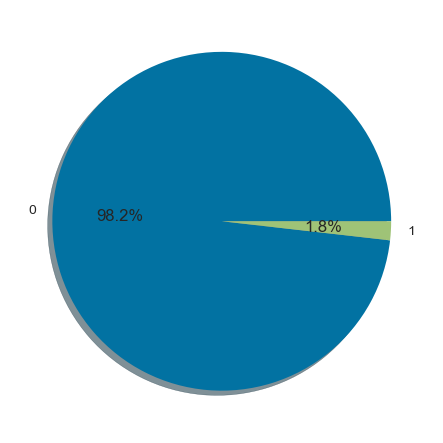

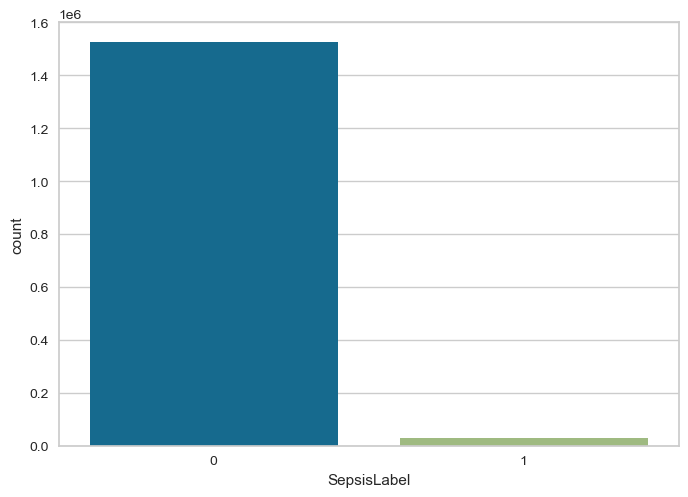

In [14]:
plt.pie(df_full['SepsisLabel'].value_counts(), labels=['0','1'], autopct='%1.1f%%', shadow=True)
plt.show()
sns.countplot(df_full['SepsisLabel'], label="Count")
plt.show()

In [15]:
len(df_full['Patient_ID'].unique())

40336

### Looking at unique patients

There are 40336 unique patients in this dataset.

In [16]:
grouped_by_patient = df_full.groupby('Patient_ID')
grouped_by_patient.sum().head()

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
Patient_ID,,,,,,,,,,,,,,,,,,,,,
1,1431,4977.0,4025.0,367.78,5326.0,3665.00,0.0,1241.0,0.0,145.0,...,20.4,0.0,655.0,4489.56,0,0.0,0.0,-1.62,1485,0
2,253,1341.0,2134.0,216.99,2049.0,1467.50,661.0,270.5,0.0,0.0,...,11.0,0.0,158.0,1745.93,0,0.0,23.0,-2267.80,276,0
3,1128,3582.5,4199.0,601.75,6301.5,3647.16,2284.5,1153.5,0.0,13.0,...,27.0,0.0,1439.0,2199.36,0,48.0,0.0,-57394.08,1176,0
4,406,2766.0,2651.5,218.73,2938.5,1745.83,720.0,491.0,0.0,0.0,...,7.6,0.0,364.0,1905.59,0,0.0,29.0,-254.33,435,0
5,1128,1774.0,2047.5,332.93,3186.5,1480.50,0.0,346.5,0.0,0.0,...,20.8,0.0,837.0,1348.32,48,48.0,0.0,-2.40,1224,0


In [17]:
# Create a list of patient IDs that belong to sepsis and nosepsis
temp = pd.DataFrame(grouped_by_patient.sum().SepsisLabel).reset_index()
sepsis_ids = temp[temp['SepsisLabel']> 0]['Patient_ID']
list_sepsis = list(sepsis_ids)
nosepsis_ids = temp[temp['SepsisLabel']== 0]['Patient_ID']
list_nosepsis = list(nosepsis_ids)

In [121]:
#sepsis_pid = np.array(grouped_by_patient[grouped_by_patient['SepsisLabel'].sum() > 0]['Patient_ID'])
# check why does this not work anymore

In [18]:
percent = len(list_sepsis)/len(df_full['Patient_ID'].unique())
print(f'There are {100*round(percent,4)}% unique patients with sepsis onset in the whole dataset.')

There are 7.2700000000000005% unique patients with sepsis onset in the whole dataset.


In [19]:
#no_sepsis_pid = np.array(grouped_by_patient[grouped_by_patient['SepsisLabel'] == 0]['Patient_ID'])
#list_no_sepsis = list(no_sepsis_pid)

There are 2932 unique patients with sepsis and 37404 patients without onset of sepsis. That is 7.27% of the all unique patients in the data. The dataset is highly unbalanced.

In [20]:
#Filter sub df for patients who have sepsis
df_sepsis = df_full[df_full['Patient_ID'].isin(list_sepsis)]
#Filter sub df for patients who do not have sepsis
df_no_sepsis = df_full[df_full['Patient_ID'].isin(list_nosepsis)]

In [21]:
df_sepsis.shape

(172410, 43)

In [22]:
df_no_sepsis.shape

(1379800, 43)

In [23]:
df_full.shape[0] == df_sepsis.shape[0] + df_no_sepsis.shape[0]


True

Output at this checkpoint

In [24]:
df_sepsis.to_csv('df_sepsis.csv', index = False)
df_no_sepsis.to_csv('df_no_sepsis.csv', index = False)

## Age distribution and gender distribution 

#### Do some hypothesis testing for
- Age = below avg and Age = above avg
- Gender = 0 and Gender = 1
- Sepsis = 0 and 1


In [37]:
data_basic_info = df_full[['Patient_ID','Age','Gender']].drop_duplicates()
data_basic_info['Sepsis'] = np.where(data_basic_info['Patient_ID'].isin(list_sepsis),1,0)
data_basic_info = data_basic_info.reset_index(drop=True)
data_basic_info


,Patient_ID,Age,Gender,Sepsis
0,17072,68.54,0,0
1,16153,46.32,1,0
2,465,85.57,0,0
3,9891,58.18,0,0
4,8065,67.00,1,0
...,...,...,...,...
40331,104763,80.00,0,0
40332,118556,27.00,0,0
40333,105149,65.00,0,0
40334,112699,64.00,1,0


In [41]:
#Create 5 year age bands

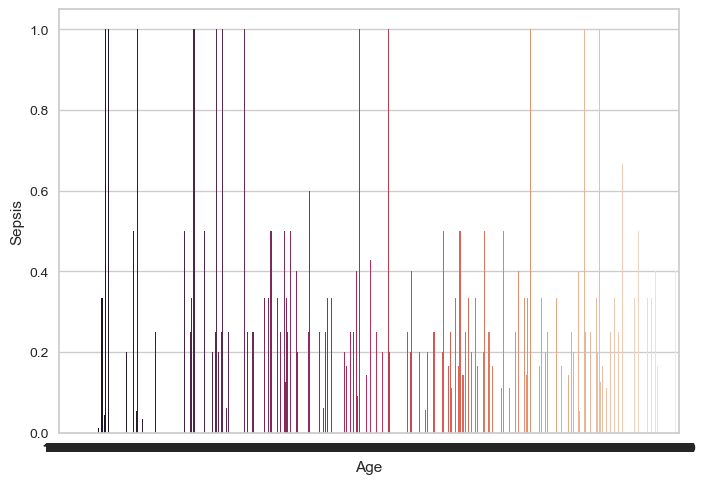

In [40]:
fig, ax1 = plt.subplots()
sns.barplot(data = data_basic_info, x = 'Age', y = 'Sepsis', ci = None,
                      ax = ax1, palette = 'rocket');

ax2 = ax1.twinx()
sns.lineplot(data = data_basic_info, x = 'Age', y = 'Booking', ax = ax2, ci = None);
plt.xlabel('Age Group Ranges');
plt.show()

# Number of hours a patient spends in Hospital

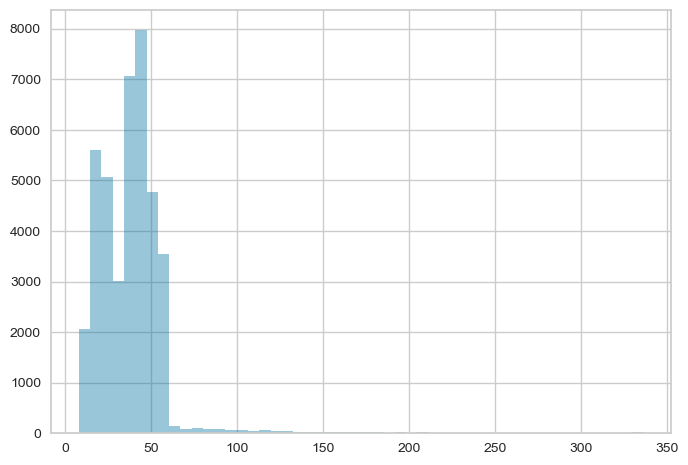

In [42]:
agg_patient_time = np.array(df_full.groupby(['Patient_ID'])['SepsisLabel'].count())
sns.distplot(agg_patient_time, kde=False);

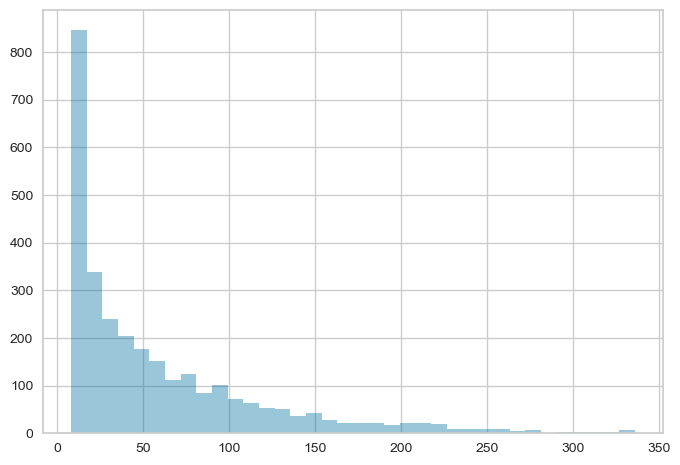

In [43]:
agg_patient_time_sepsis = np.array(df_sepsis.groupby(['Patient_ID'])['SepsisLabel'].count())

sns.distplot(agg_patient_time_sepsis, kde=False);

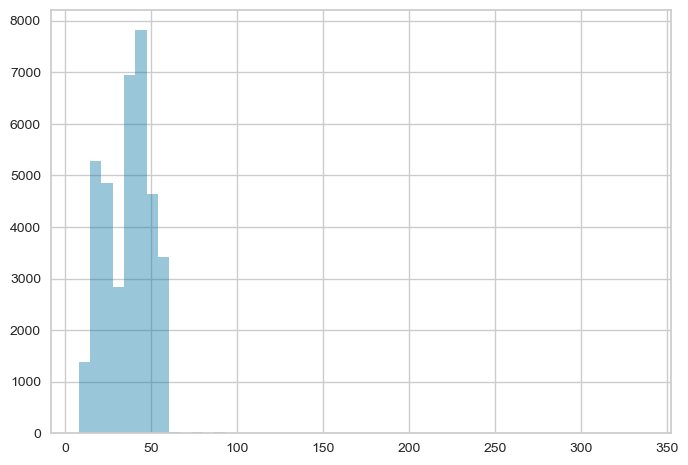

In [44]:
agg_patient_time_nosepsis = np.array(df_no_sepsis.groupby(['Patient_ID'])['SepsisLabel'].count())

sns.distplot(agg_patient_time_nosepsis, kde=False);

Patients with onset of sepsis have longer stay in the hospital, while all patients without onset of sepsis are discharged within 60 hours of admission to the hospital. This could be because patients with sepsis have serious conditions that might need longer hospitalisation to treat and monitor, instead of an indication that patients with long stay have a higher chance of sepsis onset. We would need to observe the time at which a patient contracts sepsis for this.

In [45]:
df_sepsis

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,77.0,100.0,NaN,NaN,26.5,NaN,21.00,NaN,NaN,...,NaN,NaN,59.28,1,NaN,NaN,-0.02,3,0,11093
1,1,71.5,97.5,NaN,97.0,83.5,68.0,16.50,NaN,NaN,...,NaN,158.0,59.28,1,NaN,NaN,-0.02,4,0,11093
2,2,79.0,100.0,NaN,106.0,87.0,72.0,20.75,NaN,-3.0,...,NaN,NaN,59.28,1,NaN,NaN,-0.02,5,0,11093
3,3,61.0,100.0,NaN,151.0,95.0,90.0,16.00,NaN,-3.0,...,NaN,NaN,59.28,1,NaN,NaN,-0.02,6,0,11093
4,4,49.0,100.0,NaN,145.0,92.0,84.0,20.00,NaN,-1.0,...,NaN,NaN,59.28,1,NaN,NaN,-0.02,7,0,11093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,5,54.5,98.5,37.2,104.5,74.0,55.0,NaN,31.5,NaN,...,NaN,NaN,66.00,1,1.0,0.0,0.00,6,1,119010
6,6,54.0,96.0,NaN,112.0,74.0,52.0,NaN,37.0,NaN,...,NaN,NaN,66.00,1,1.0,0.0,0.00,7,1,119010
7,7,67.5,96.5,NaN,118.0,77.0,55.0,NaN,38.0,NaN,...,NaN,NaN,66.00,1,1.0,0.0,0.00,8,1,119010
8,8,67.0,96.0,NaN,115.5,76.0,55.5,NaN,NaN,NaN,...,NaN,NaN,66.00,1,1.0,0.0,0.00,9,1,119010


In [46]:
df_sepsis['Hour'][::-1].iloc[0] #This gives the total length of hospital stay for the sepsis patient

9

# Time of sepsis onset for sepsis patients

In [47]:
pid_list =[]
sepsis_time_hr = []
sepsis_time_iculos = []
tot_time = []

for pid in list_sepsis:
    temp = df_sepsis[df_sepsis['Patient_ID'] == pid]
    pid_list.append(pid)
    sepsis_time_hr.append(temp[temp['SepsisLabel'] == 1].head(1).iloc[0].Hour)
    sepsis_time_iculos.append(temp[temp['SepsisLabel'] == 1].head(1).iloc[0].ICULOS)
    tot_time.append(temp['Hour'][::-1].iloc[0])
  

In [48]:
sepsis_onset_hr = dict(zip(pid_list,sepsis_time_hr))

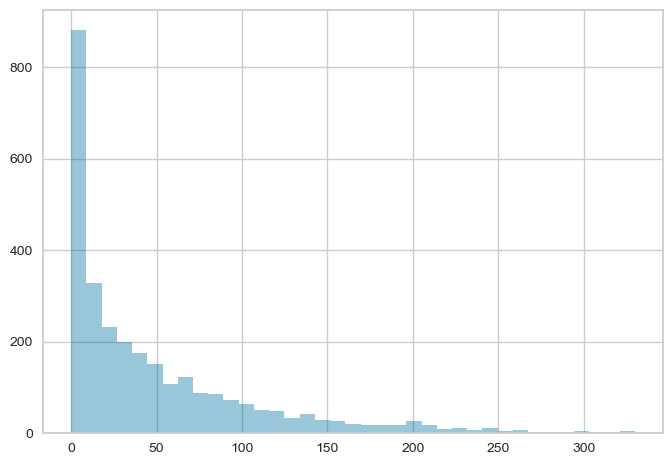

In [49]:
sns.distplot(sepsis_time_hr, kde=False);


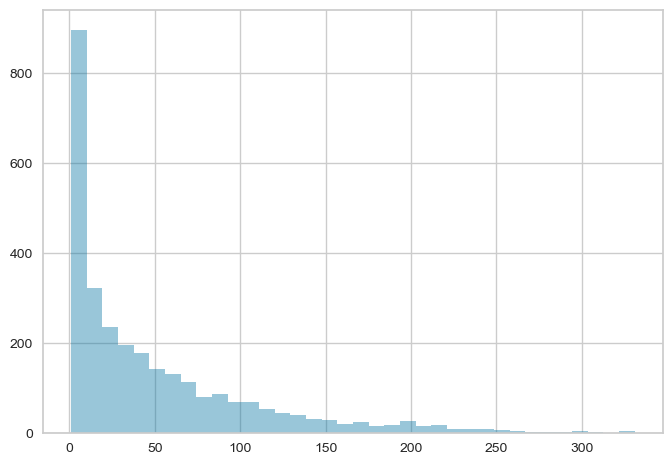

In [50]:
sns.distplot(sepsis_time_iculos, kde=False);


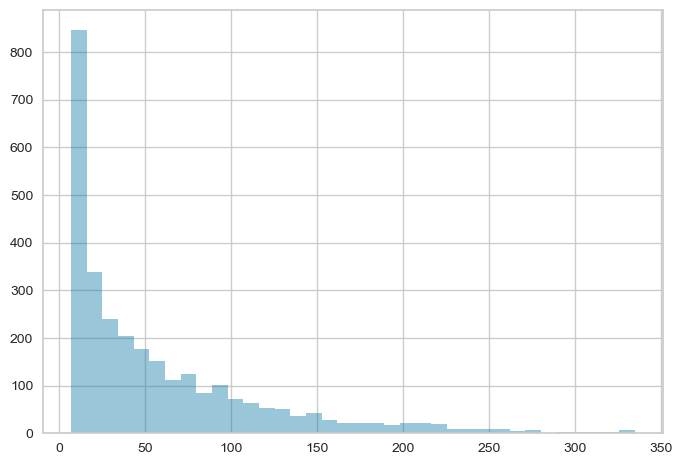

In [51]:
sns.distplot(tot_time, kde=False);

The two graphs are similar (time of sepsis onset vs. total amount of time sepsis patients stayed in hospital).

<AxesSubplot:>

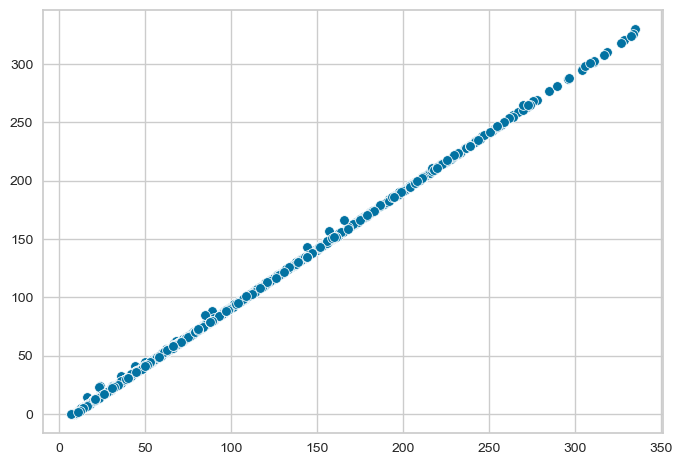

In [52]:
sns.scatterplot(tot_time, sepsis_time_hr)

<AxesSubplot:>

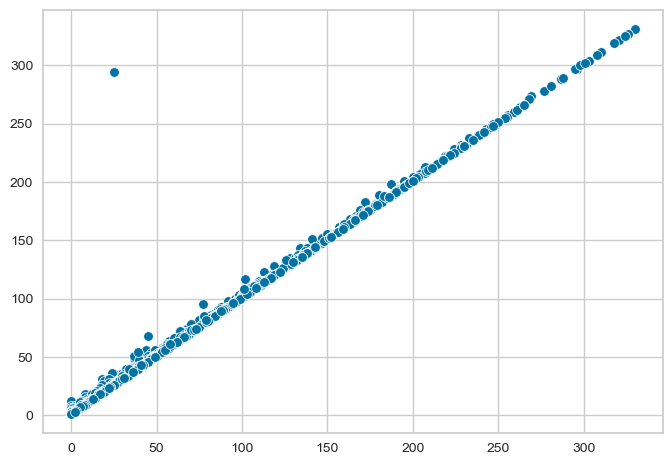

In [53]:
sns.scatterplot(sepsis_time_hr, sepsis_time_iculos)


In [54]:
testdf = pd.DataFrame(sepsis_time_hr)
testdf.columns = ['sepsis_onset']
#

In [56]:
# Find the #median out of 2932 patients with sepsis onset

## Do Lab Measured Values Serve as an Indicator

In [60]:
col_vitalsigns = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2']
col_labvalues = ['BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets']
col_demographics = ['Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS']

In [68]:
#Need to write my own function here.

In [69]:
def check_if_measurement_indicates_sepsis(s): # s is the lab measurement
    """ Checks if a given lab measurement being measured is an indicator of sepsis. """
    
    # Get ids of those that have the value measured
    ids_measured = s[s > 0].index.get_level_values('id').unique()
    ids_measured_septic = [x for x in ids_measured if x in list_sepsis]
    
    # Get those without a measurement
    ids_not_measured = [x for x in s.index.get_level_values('id').unique() if x not in ids_measured]
    ids_not_measured_septic = [x for x in ids_not_measured if x in ids_eventual]
    
    # Print info if specified
    measured_pcnt = len(ids_measured_septic) / len(ids_measured)
    not_measured_pcnt = len(ids_not_measured_septic) / len(ids_not_measured)
    
    print('If {} was measured: {:.3f}% septic. Num cases = {}.'.format(s.name, measured_pcnt * 100, len(ids_measured)))
    print('If {} was not measured: {:.3f}% septic. Num cases = {}.'.format(s.name, not_measured_pcnt * 100, len(ids_not_measured)))
        
    return measured_pcnt, not_measured_pcnt

In [71]:
for x in df_full[col_labvalues]:
    check_if_measurement_indicates_sepsis(df_full[x])
    print('')

KeyError: 'Requested level (id) does not match index name (None)'

# Dealing with Null values

In [64]:
col_vitalsigns = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2']
col_labvalues = ['BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets']
col_demographics = ['Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS']

In [65]:
#missing values
df_notna = df_full.notnull().sum()
df_na = df_full.isna().sum()

#Visualise percentage of missing values
missing_values = pd.DataFrame(100*df_na/(df_notna+df_na))#, columns = 'Percentage_missing')
missing_values.columns = ['Percentage_missing_values']
missing_values

,Percentage_missing_values
Hour,0.000000
HR,9.882619
O2Sat,13.061119
Temp,66.162697
SBP,14.576958
MAP,12.451279
DBP,31.345887
Resp,15.354559
EtCO2,96.286843
BaseExcess,94.579020


## Missing Values  - 1
### Vital Signs

Many of the variables in the dataset are sparse, as is expected with clinical data. However, for vital signs columns such as HR, MAP, O2Sat, SBP, DBP, Resp have about 30% or less missing data. For these variables, any missing data is replaced with backfilling the most recent non-NaN value.

For other vital signs columns (Temp, EtCO2), we will do the same and examine the number of NaN values after


In [66]:
list_patients = df_full['Patient_ID'].unique()
for y in list_patients:
    df_full[df_full['Patient_ID'] == y] = df_full[df_full['Patient_ID'] == y].fillna(method= 'bfill', axis=0).fillna(method= 'ffill', axis=0) 
    

df_full.head()
    
#Is there a way to fill values more efficiently? using groupby?
#more efficient method?
#grouped_by_patient = df_full.groupby('Patient_ID')
#for patient, group in grouped_by_patient:
    #print(patient)
#    group = group.reset_index(drop=True)

    #backfill any missing values for the continuous variables with < 15% missing data
#    group = group.assign(HR=group['HR'].fillna(method='bfill').fillna(method='ffill'))
#    group = group.assign(MAP=group['MAP'].fillna(method='bfill').fillna(method='ffill'))
#    group = group.assign(O2Sat=group['O2Sat'].fillna(method='bfill').fillna(method='ffill'))
#    group = group.assign(SBP=group['SBP'].fillna(method='bfill').fillna(method='ffill'))
#    group = group.assign(Resp=group['Resp'].fillna(method='bfill').fillna(method='ffill'))

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,65.0,100.0,35.78,129.0,72.0,69.0,16.5,NaN,6.0,...,NaN,330.0,68.54,0,NaN,NaN,-0.02,1,0,17072
1,1,65.0,100.0,35.78,129.0,72.0,69.0,16.5,NaN,6.0,...,NaN,330.0,68.54,0,NaN,NaN,-0.02,2,0,17072
2,2,78.0,100.0,35.78,129.0,42.5,69.0,17.0,NaN,6.0,...,NaN,330.0,68.54,0,NaN,NaN,-0.02,3,0,17072
3,3,73.0,100.0,35.78,129.0,74.0,69.0,17.0,NaN,6.0,...,NaN,330.0,68.54,0,NaN,NaN,-0.02,4,0,17072
4,4,70.0,100.0,35.78,129.0,74.0,69.0,14.0,NaN,6.0,...,NaN,330.0,68.54,0,NaN,NaN,-0.02,5,0,17072


## Missing Values - 2

For the remainder of the variables, summarize the window of ten hours with the median of the values in that window. If all the values in that window are NaN, then just report the median as NaN.

## Missing Values - 3
### Demographics

`Unit1` and `Unit2` both have 39% missing values, and they are the administrative identifiers for ICU Unit (MICU and SICU for Units 1 and 2 respectively). MICU stands for medical intensive care unit, while SICU is a surgical intensive care unit. They can be dropped from the dataset. The other demographics columns do not have NaN values.

In [67]:
df_full = df_full.drop(columns =['Unit1', 'Unit2'])

#missing values after imputation
df_na = df_full.isna().sum()
df_notna = df_full.notnull().sum()
#Visualise percentage of missing values
missing_values = pd.DataFrame(100*df_na/(df_notna+df_na))#, columns = 'Percentage_missing')
missing_values.columns = ['Percentage_missing_values']
missing_values

,Percentage_missing_values
Hour,0.000000
HR,0.009148
O2Sat,0.024095
Temp,0.478672
SBP,0.707121
MAP,0.173817
DBP,16.701993
Resp,0.128784
EtCO2,89.938861
BaseExcess,63.709743


# Preparing data for modelling

In [80]:
#Filter sub df for patients who have sepsis and no sepsis
df_sepsis = df_full[df_full['Patient_ID'].isin(list_sepsis)]
df_no_sepsis = df_full[df_full['Patient_ID'].isin(list_nosepsis)]

In [73]:
#save at checkpoint
df_sepsis.to_csv('df_sepsis.csv', index = False)
df_no_sepsis.to_csv('df_no_sepsis.csv', index = False)

In [74]:
#df_full['Patient_ID'] = pd.to_numeric(df_full['Patient_ID'])
#df_subset = df_full[df_full['Patient_ID'] <= 100]
df_sepsis.head()

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,PTT,WBC,Fibrinogen,Platelets,Age,Gender,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,77.0,100.0,NaN,97.0,26.5,68.0,21.00,NaN,-3.0,...,27.2,17.7,NaN,158.0,59.28,1,-0.02,3,0,11093
1,1,71.5,97.5,NaN,97.0,83.5,68.0,16.50,NaN,-3.0,...,27.2,17.7,NaN,158.0,59.28,1,-0.02,4,0,11093
2,2,79.0,100.0,NaN,106.0,87.0,72.0,20.75,NaN,-3.0,...,27.2,17.7,NaN,138.0,59.28,1,-0.02,5,0,11093
3,3,61.0,100.0,NaN,151.0,95.0,90.0,16.00,NaN,-3.0,...,27.2,13.0,NaN,138.0,59.28,1,-0.02,6,0,11093
4,4,49.0,100.0,NaN,145.0,92.0,84.0,20.00,NaN,-1.0,...,27.2,13.0,NaN,138.0,59.28,1,-0.02,7,0,11093


In [75]:
data_ages = df_full[['Patient_ID','Age']].drop_duplicates()
ages = dict(zip(data_ages['Patient_ID'],data_ages['Age']))

In [76]:
data_gender = df_full[['Patient_ID','Gender']].drop_duplicates()
gender = dict(zip(data_gender['Patient_ID'],data_gender['Gender']))

In [77]:
data_hospadm = df_full[['Patient_ID','HospAdmTime']].drop_duplicates()
hospadm = dict(zip(data_hospadm['Patient_ID'],data_hospadm['HospAdmTime']))

In [78]:
grouped_by_patient_sepsis = df_sepsis.groupby('Patient_ID')
grouped_by_patient_no_sepsis = df_no_sepsis.groupby('Patient_ID')

In [79]:
# Create a dictionary of all the patient_ID and the hour of onset
sepsis_onset_hr = dict(zip(pid_list,sepsis_time_hr))

In [83]:
cols_vital = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp']
cols_lab = ['BUN', 'Calcium', 'Creatinine', 'Glucose', 'Magnesium', 'Phosphate', 
            'Potassium', 'Hct', 'Hgb', 'WBC', 'Platelets']

cols_dummify = ['EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'Alkalinephos', 'Chloride',
                'Bilirubin_direct', 'Lactate', 'Bilirubin_total', 'Troponinl','PTT', 'Fibrinogen']
               
cols_demographic = ['Age', 'Gender', 'HospAdmTime']

cols_to_drop = ['Unit1' , 'Unit2']

In [84]:
win_len = 3
pred_len = 1
window_list = []
count = 0

for patient, group in grouped_by_patient_sepsis:
    count +=1 
    print(count, " : patient ",patient)
    
    x = int(sepsis_onset_hr[patient])
    
    temp_data = group.iloc[x-win_len : x] #x-win_len+pred_len] #check this
    
    temp_val_vital = temp_data[cols_vital].mean()
    temp_val_lab = temp_data[cols_lab].mean()
    
    temp_val = pd.concat([temp_val_vital, temp_val_lab],axis=0)
    testdf = pd.DataFrame(temp_val).T
    
    testdf['Patient'] = patient
    testdf['SepsisOnsetHour'] = x
    testdf['SepsisLabel'] = 1
    testdf['Age'] = ages[patient]
    testdf['Gender'] = gender[patient]
    testdf['HospAdmTime'] = hospadm[patient]
    
    window_list.append(testdf)

df_modelling_sepsis = pd.concat(window_list).reset_index(drop=True)
#df_modelling_sepsis

1  : patient  9
2  : patient  11
3  : patient  15
4  : patient  18
5  : patient  22
6  : patient  28
7  : patient  34
8  : patient  42
9  : patient  53
10  : patient  56
11  : patient  58
12  : patient  63
13  : patient  64
14  : patient  78
15  : patient  141
16  : patient  161
17  : patient  171
18  : patient  178
19  : patient  185
20  : patient  188
21  : patient  203
22  : patient  206
23  : patient  211
24  : patient  226
25  : patient  260
26  : patient  265
27  : patient  272
28  : patient  283
29  : patient  286
30  : patient  311
31  : patient  324
32  : patient  346
33  : patient  354
34  : patient  357
35  : patient  359
36  : patient  371
37  : patient  373
38  : patient  376
39  : patient  379
40  : patient  384
41  : patient  401
42  : patient  403
43  : patient  466
44  : patient  468
45  : patient  483
46  : patient  524
47  : patient  541
48  : patient  545
49  : patient  559
50  : patient  574
51  : patient  584
52  : patient  587
53  : patient  601
54  : patient  61

445  : patient  4986
446  : patient  4988
447  : patient  5007
448  : patient  5026
449  : patient  5037
450  : patient  5038
451  : patient  5053
452  : patient  5079
453  : patient  5091
454  : patient  5092
455  : patient  5099
456  : patient  5112
457  : patient  5129
458  : patient  5154
459  : patient  5179
460  : patient  5186
461  : patient  5188
462  : patient  5191
463  : patient  5198
464  : patient  5211
465  : patient  5233
466  : patient  5234
467  : patient  5251
468  : patient  5259
469  : patient  5277
470  : patient  5294
471  : patient  5316
472  : patient  5317
473  : patient  5322
474  : patient  5325
475  : patient  5328
476  : patient  5338
477  : patient  5359
478  : patient  5386
479  : patient  5391
480  : patient  5394
481  : patient  5406
482  : patient  5416
483  : patient  5418
484  : patient  5425
485  : patient  5427
486  : patient  5429
487  : patient  5438
488  : patient  5457
489  : patient  5462
490  : patient  5500
491  : patient  5508
492  : patien

886  : patient  10264
887  : patient  10280
888  : patient  10289
889  : patient  10308
890  : patient  10339
891  : patient  10349
892  : patient  10355
893  : patient  10377
894  : patient  10387
895  : patient  10389
896  : patient  10416
897  : patient  10418
898  : patient  10427
899  : patient  10441
900  : patient  10461
901  : patient  10482
902  : patient  10490
903  : patient  10491
904  : patient  10497
905  : patient  10540
906  : patient  10549
907  : patient  10580
908  : patient  10606
909  : patient  10627
910  : patient  10628
911  : patient  10631
912  : patient  10634
913  : patient  10645
914  : patient  10652
915  : patient  10656
916  : patient  10664
917  : patient  10665
918  : patient  10682
919  : patient  10686
920  : patient  10700
921  : patient  10705
922  : patient  10710
923  : patient  10740
924  : patient  10741
925  : patient  10755
926  : patient  10756
927  : patient  10771
928  : patient  10778
929  : patient  10782
930  : patient  10804
931  : pat

1272  : patient  14547
1273  : patient  14556
1274  : patient  14560
1275  : patient  14563
1276  : patient  14565
1277  : patient  14574
1278  : patient  14577
1279  : patient  14590
1280  : patient  14597
1281  : patient  14601
1282  : patient  14602
1283  : patient  14606
1284  : patient  14614
1285  : patient  14640
1286  : patient  14642
1287  : patient  14674
1288  : patient  14684
1289  : patient  14727
1290  : patient  14728
1291  : patient  14746
1292  : patient  14763
1293  : patient  14764
1294  : patient  14765
1295  : patient  14769
1296  : patient  14771
1297  : patient  14774
1298  : patient  14795
1299  : patient  14798
1300  : patient  14807
1301  : patient  14813
1302  : patient  14820
1303  : patient  14823
1304  : patient  14824
1305  : patient  14841
1306  : patient  14855
1307  : patient  14876
1308  : patient  14880
1309  : patient  14881
1310  : patient  14882
1311  : patient  14887
1312  : patient  14888
1313  : patient  14895
1314  : patient  14899
1315  : pat

1647  : patient  18857
1648  : patient  18860
1649  : patient  18871
1650  : patient  18872
1651  : patient  18909
1652  : patient  18911
1653  : patient  18930
1654  : patient  18941
1655  : patient  18953
1656  : patient  18958
1657  : patient  18986
1658  : patient  18987
1659  : patient  18994
1660  : patient  18998
1661  : patient  19007
1662  : patient  19010
1663  : patient  19049
1664  : patient  19050
1665  : patient  19061
1666  : patient  19072
1667  : patient  19094
1668  : patient  19095
1669  : patient  19098
1670  : patient  19109
1671  : patient  19114
1672  : patient  19149
1673  : patient  19153
1674  : patient  19170
1675  : patient  19175
1676  : patient  19185
1677  : patient  19207
1678  : patient  19210
1679  : patient  19222
1680  : patient  19228
1681  : patient  19231
1682  : patient  19237
1683  : patient  19240
1684  : patient  19245
1685  : patient  19249
1686  : patient  19256
1687  : patient  19268
1688  : patient  19282
1689  : patient  19304
1690  : pat

2041  : patient  104483
2042  : patient  104500
2043  : patient  104507
2044  : patient  104524
2045  : patient  104530
2046  : patient  104535
2047  : patient  104541
2048  : patient  104545
2049  : patient  104592
2050  : patient  104605
2051  : patient  104616
2052  : patient  104624
2053  : patient  104666
2054  : patient  104728
2055  : patient  104734
2056  : patient  104738
2057  : patient  104754
2058  : patient  104758
2059  : patient  104769
2060  : patient  104780
2061  : patient  104785
2062  : patient  104787
2063  : patient  104800
2064  : patient  104801
2065  : patient  104804
2066  : patient  104893
2067  : patient  104932
2068  : patient  104980
2069  : patient  104996
2070  : patient  105017
2071  : patient  105030
2072  : patient  105038
2073  : patient  105042
2074  : patient  105045
2075  : patient  105055
2076  : patient  105061
2077  : patient  105081
2078  : patient  105102
2079  : patient  105122
2080  : patient  105180
2081  : patient  105190
2082  : patient 

2429  : patient  111449
2430  : patient  111465
2431  : patient  111466
2432  : patient  111478
2433  : patient  111483
2434  : patient  111512
2435  : patient  111523
2436  : patient  111529
2437  : patient  111537
2438  : patient  111540
2439  : patient  111554
2440  : patient  111580
2441  : patient  111593
2442  : patient  111657
2443  : patient  111690
2444  : patient  111692
2445  : patient  111695
2446  : patient  111697
2447  : patient  111699
2448  : patient  111706
2449  : patient  111750
2450  : patient  111806
2451  : patient  111809
2452  : patient  111823
2453  : patient  111849
2454  : patient  111854
2455  : patient  111856
2456  : patient  111860
2457  : patient  111870
2458  : patient  111890
2459  : patient  111891
2460  : patient  111908
2461  : patient  111920
2462  : patient  111945
2463  : patient  112050
2464  : patient  112060
2465  : patient  112097
2466  : patient  112115
2467  : patient  112134
2468  : patient  112153
2469  : patient  112155
2470  : patient 

2802  : patient  118030
2803  : patient  118058
2804  : patient  118069
2805  : patient  118083
2806  : patient  118154
2807  : patient  118155
2808  : patient  118166
2809  : patient  118213
2810  : patient  118230
2811  : patient  118231
2812  : patient  118264
2813  : patient  118265
2814  : patient  118275
2815  : patient  118286
2816  : patient  118292
2817  : patient  118298
2818  : patient  118306
2819  : patient  118311
2820  : patient  118313
2821  : patient  118385
2822  : patient  118386
2823  : patient  118388
2824  : patient  118396
2825  : patient  118429
2826  : patient  118431
2827  : patient  118440
2828  : patient  118445
2829  : patient  118449
2830  : patient  118461
2831  : patient  118501
2832  : patient  118515
2833  : patient  118522
2834  : patient  118529
2835  : patient  118539
2836  : patient  118572
2837  : patient  118577
2838  : patient  118583
2839  : patient  118611
2840  : patient  118613
2841  : patient  118620
2842  : patient  118630
2843  : patient 

In [85]:
window_list = []
count = 0
for patient, group in grouped_by_patient_no_sepsis:
    count +=1 
    print(count, " : patient ",patient)
    
    x = 28
    
    temp_data = group.iloc[x-win_len : x] #x-win_len+pred_len] #check this
    
    temp_val_vital = temp_data[cols_vital].mean()
    temp_val_lab = temp_data[cols_lab].mean()
    
    temp_val = pd.concat([temp_val_vital, temp_val_lab],axis=0)
    testdf = pd.DataFrame(temp_val).T
    
    testdf['Patient'] = patient
    testdf['SepsisOnsetHour'] = x
    testdf['SepsisLabel'] = 0
    testdf['Age'] = ages[patient]
    testdf['Gender'] = gender[patient]
    testdf['HospAdmTime'] = hospadm[patient]
    
    window_list.append(testdf)

df_modelling_no_sepsis = pd.concat(window_list).reset_index(drop=True)

1  : patient  1
2  : patient  2
3  : patient  3
4  : patient  4
5  : patient  5
6  : patient  6
7  : patient  7
8  : patient  8
9  : patient  10
10  : patient  12
11  : patient  13
12  : patient  14
13  : patient  16
14  : patient  17
15  : patient  19
16  : patient  20
17  : patient  21
18  : patient  23
19  : patient  24
20  : patient  25
21  : patient  26
22  : patient  27
23  : patient  29
24  : patient  30
25  : patient  31
26  : patient  32
27  : patient  33
28  : patient  35
29  : patient  36
30  : patient  37
31  : patient  38
32  : patient  39
33  : patient  40
34  : patient  41
35  : patient  43
36  : patient  44
37  : patient  45
38  : patient  46
39  : patient  47
40  : patient  48
41  : patient  49
42  : patient  50
43  : patient  51
44  : patient  52
45  : patient  54
46  : patient  55
47  : patient  57
48  : patient  59
49  : patient  60
50  : patient  61
51  : patient  62
52  : patient  65
53  : patient  66
54  : patient  67
55  : patient  68
56  : patient  69
57  : pat

453  : patient  498
454  : patient  499
455  : patient  500
456  : patient  501
457  : patient  502
458  : patient  503
459  : patient  504
460  : patient  505
461  : patient  506
462  : patient  507
463  : patient  508
464  : patient  509
465  : patient  510
466  : patient  511
467  : patient  512
468  : patient  513
469  : patient  514
470  : patient  515
471  : patient  516
472  : patient  517
473  : patient  518
474  : patient  519
475  : patient  520
476  : patient  521
477  : patient  522
478  : patient  523
479  : patient  525
480  : patient  526
481  : patient  527
482  : patient  528
483  : patient  529
484  : patient  530
485  : patient  531
486  : patient  532
487  : patient  533
488  : patient  534
489  : patient  535
490  : patient  536
491  : patient  537
492  : patient  538
493  : patient  539
494  : patient  540
495  : patient  542
496  : patient  543
497  : patient  544
498  : patient  546
499  : patient  547
500  : patient  548
501  : patient  549
502  : patient  550


877  : patient  961
878  : patient  963
879  : patient  964
880  : patient  965
881  : patient  966
882  : patient  968
883  : patient  969
884  : patient  970
885  : patient  971
886  : patient  973
887  : patient  974
888  : patient  975
889  : patient  976
890  : patient  977
891  : patient  978
892  : patient  979
893  : patient  980
894  : patient  981
895  : patient  982
896  : patient  984
897  : patient  985
898  : patient  986
899  : patient  987
900  : patient  988
901  : patient  989
902  : patient  990
903  : patient  991
904  : patient  992
905  : patient  993
906  : patient  994
907  : patient  995
908  : patient  997
909  : patient  998
910  : patient  1000
911  : patient  1001
912  : patient  1002
913  : patient  1003
914  : patient  1004
915  : patient  1005
916  : patient  1006
917  : patient  1007
918  : patient  1008
919  : patient  1009
920  : patient  1010
921  : patient  1011
922  : patient  1012
923  : patient  1013
924  : patient  1014
925  : patient  1015
926 

1349  : patient  1492
1350  : patient  1493
1351  : patient  1494
1352  : patient  1495
1353  : patient  1496
1354  : patient  1497
1355  : patient  1498
1356  : patient  1499
1357  : patient  1500
1358  : patient  1501
1359  : patient  1503
1360  : patient  1504
1361  : patient  1505
1362  : patient  1506
1363  : patient  1507
1364  : patient  1508
1365  : patient  1509
1366  : patient  1510
1367  : patient  1511
1368  : patient  1512
1369  : patient  1513
1370  : patient  1514
1371  : patient  1515
1372  : patient  1516
1373  : patient  1517
1374  : patient  1518
1375  : patient  1520
1376  : patient  1521
1377  : patient  1522
1378  : patient  1524
1379  : patient  1525
1380  : patient  1526
1381  : patient  1527
1382  : patient  1528
1383  : patient  1529
1384  : patient  1530
1385  : patient  1531
1386  : patient  1532
1387  : patient  1533
1388  : patient  1534
1389  : patient  1535
1390  : patient  1536
1391  : patient  1537
1392  : patient  1538
1393  : patient  1539
1394  : pa

1775  : patient  1958
1776  : patient  1959
1777  : patient  1960
1778  : patient  1961
1779  : patient  1962
1780  : patient  1963
1781  : patient  1964
1782  : patient  1965
1783  : patient  1966
1784  : patient  1967
1785  : patient  1968
1786  : patient  1969
1787  : patient  1970
1788  : patient  1971
1789  : patient  1972
1790  : patient  1973
1791  : patient  1974
1792  : patient  1975
1793  : patient  1976
1794  : patient  1977
1795  : patient  1978
1796  : patient  1979
1797  : patient  1980
1798  : patient  1981
1799  : patient  1982
1800  : patient  1983
1801  : patient  1984
1802  : patient  1985
1803  : patient  1986
1804  : patient  1987
1805  : patient  1988
1806  : patient  1989
1807  : patient  1990
1808  : patient  1991
1809  : patient  1992
1810  : patient  1994
1811  : patient  1995
1812  : patient  1996
1813  : patient  1997
1814  : patient  1998
1815  : patient  1999
1816  : patient  2000
1817  : patient  2001
1818  : patient  2002
1819  : patient  2003
1820  : pa

2179  : patient  2392
2180  : patient  2393
2181  : patient  2394
2182  : patient  2395
2183  : patient  2396
2184  : patient  2397
2185  : patient  2398
2186  : patient  2400
2187  : patient  2401
2188  : patient  2402
2189  : patient  2403
2190  : patient  2405
2191  : patient  2406
2192  : patient  2407
2193  : patient  2408
2194  : patient  2409
2195  : patient  2410
2196  : patient  2411
2197  : patient  2412
2198  : patient  2413
2199  : patient  2414
2200  : patient  2415
2201  : patient  2416
2202  : patient  2417
2203  : patient  2418
2204  : patient  2419
2205  : patient  2420
2206  : patient  2421
2207  : patient  2422
2208  : patient  2423
2209  : patient  2424
2210  : patient  2426
2211  : patient  2427
2212  : patient  2428
2213  : patient  2430
2214  : patient  2431
2215  : patient  2432
2216  : patient  2433
2217  : patient  2434
2218  : patient  2435
2219  : patient  2436
2220  : patient  2437
2221  : patient  2438
2222  : patient  2439
2223  : patient  2440
2224  : pa

2598  : patient  2849
2599  : patient  2850
2600  : patient  2851
2601  : patient  2854
2602  : patient  2855
2603  : patient  2856
2604  : patient  2857
2605  : patient  2858
2606  : patient  2859
2607  : patient  2860
2608  : patient  2861
2609  : patient  2862
2610  : patient  2863
2611  : patient  2864
2612  : patient  2865
2613  : patient  2866
2614  : patient  2867
2615  : patient  2868
2616  : patient  2869
2617  : patient  2870
2618  : patient  2871
2619  : patient  2873
2620  : patient  2874
2621  : patient  2875
2622  : patient  2876
2623  : patient  2877
2624  : patient  2878
2625  : patient  2879
2626  : patient  2882
2627  : patient  2883
2628  : patient  2885
2629  : patient  2886
2630  : patient  2887
2631  : patient  2888
2632  : patient  2889
2633  : patient  2890
2634  : patient  2891
2635  : patient  2892
2636  : patient  2893
2637  : patient  2894
2638  : patient  2895
2639  : patient  2896
2640  : patient  2897
2641  : patient  2898
2642  : patient  2899
2643  : pa

2985  : patient  3284
2986  : patient  3285
2987  : patient  3286
2988  : patient  3287
2989  : patient  3288
2990  : patient  3289
2991  : patient  3290
2992  : patient  3291
2993  : patient  3292
2994  : patient  3293
2995  : patient  3294
2996  : patient  3295
2997  : patient  3296
2998  : patient  3297
2999  : patient  3298
3000  : patient  3299
3001  : patient  3300
3002  : patient  3301
3003  : patient  3302
3004  : patient  3303
3005  : patient  3304
3006  : patient  3305
3007  : patient  3306
3008  : patient  3307
3009  : patient  3309
3010  : patient  3310
3011  : patient  3311
3012  : patient  3312
3013  : patient  3313
3014  : patient  3314
3015  : patient  3315
3016  : patient  3316
3017  : patient  3317
3018  : patient  3318
3019  : patient  3319
3020  : patient  3320
3021  : patient  3322
3022  : patient  3324
3023  : patient  3326
3024  : patient  3327
3025  : patient  3328
3026  : patient  3329
3027  : patient  3330
3028  : patient  3331
3029  : patient  3333
3030  : pa

3404  : patient  3747
3405  : patient  3748
3406  : patient  3749
3407  : patient  3750
3408  : patient  3751
3409  : patient  3753
3410  : patient  3754
3411  : patient  3755
3412  : patient  3756
3413  : patient  3757
3414  : patient  3758
3415  : patient  3759
3416  : patient  3760
3417  : patient  3761
3418  : patient  3762
3419  : patient  3763
3420  : patient  3764
3421  : patient  3765
3422  : patient  3766
3423  : patient  3767
3424  : patient  3769
3425  : patient  3770
3426  : patient  3771
3427  : patient  3772
3428  : patient  3773
3429  : patient  3774
3430  : patient  3775
3431  : patient  3776
3432  : patient  3777
3433  : patient  3779
3434  : patient  3780
3435  : patient  3781
3436  : patient  3782
3437  : patient  3783
3438  : patient  3784
3439  : patient  3785
3440  : patient  3786
3441  : patient  3787
3442  : patient  3788
3443  : patient  3789
3444  : patient  3790
3445  : patient  3792
3446  : patient  3793
3447  : patient  3794
3448  : patient  3795
3449  : pa

3819  : patient  4196
3820  : patient  4198
3821  : patient  4199
3822  : patient  4201
3823  : patient  4202
3824  : patient  4203
3825  : patient  4204
3826  : patient  4205
3827  : patient  4206
3828  : patient  4207
3829  : patient  4208
3830  : patient  4210
3831  : patient  4211
3832  : patient  4212
3833  : patient  4213
3834  : patient  4214
3835  : patient  4215
3836  : patient  4216
3837  : patient  4217
3838  : patient  4218
3839  : patient  4219
3840  : patient  4220
3841  : patient  4221
3842  : patient  4222
3843  : patient  4224
3844  : patient  4225
3845  : patient  4226
3846  : patient  4227
3847  : patient  4228
3848  : patient  4229
3849  : patient  4230
3850  : patient  4231
3851  : patient  4232
3852  : patient  4233
3853  : patient  4234
3854  : patient  4235
3855  : patient  4236
3856  : patient  4237
3857  : patient  4238
3858  : patient  4239
3859  : patient  4240
3860  : patient  4241
3861  : patient  4242
3862  : patient  4244
3863  : patient  4245
3864  : pa

4193  : patient  4594
4194  : patient  4595
4195  : patient  4596
4196  : patient  4597
4197  : patient  4598
4198  : patient  4600
4199  : patient  4601
4200  : patient  4602
4201  : patient  4603
4202  : patient  4604
4203  : patient  4605
4204  : patient  4606
4205  : patient  4607
4206  : patient  4608
4207  : patient  4609
4208  : patient  4610
4209  : patient  4611
4210  : patient  4612
4211  : patient  4613
4212  : patient  4614
4213  : patient  4615
4214  : patient  4616
4215  : patient  4617
4216  : patient  4619
4217  : patient  4620
4218  : patient  4621
4219  : patient  4622
4220  : patient  4623
4221  : patient  4624
4222  : patient  4625
4223  : patient  4626
4224  : patient  4627
4225  : patient  4628
4226  : patient  4631
4227  : patient  4632
4228  : patient  4633
4229  : patient  4635
4230  : patient  4636
4231  : patient  4637
4232  : patient  4638
4233  : patient  4639
4234  : patient  4640
4235  : patient  4641
4236  : patient  4643
4237  : patient  4644
4238  : pa

4589  : patient  5039
4590  : patient  5040
4591  : patient  5041
4592  : patient  5042
4593  : patient  5043
4594  : patient  5044
4595  : patient  5045
4596  : patient  5046
4597  : patient  5047
4598  : patient  5048
4599  : patient  5049
4600  : patient  5050
4601  : patient  5051
4602  : patient  5052
4603  : patient  5054
4604  : patient  5055
4605  : patient  5056
4606  : patient  5057
4607  : patient  5058
4608  : patient  5059
4609  : patient  5060
4610  : patient  5061
4611  : patient  5062
4612  : patient  5063
4613  : patient  5064
4614  : patient  5065
4615  : patient  5066
4616  : patient  5067
4617  : patient  5068
4618  : patient  5069
4619  : patient  5070
4620  : patient  5071
4621  : patient  5072
4622  : patient  5073
4623  : patient  5074
4624  : patient  5075
4625  : patient  5076
4626  : patient  5077
4627  : patient  5078
4628  : patient  5080
4629  : patient  5081
4630  : patient  5082
4631  : patient  5083
4632  : patient  5084
4633  : patient  5085
4634  : pa

5040  : patient  5534
5041  : patient  5535
5042  : patient  5536
5043  : patient  5537
5044  : patient  5538
5045  : patient  5540
5046  : patient  5541
5047  : patient  5542
5048  : patient  5543
5049  : patient  5544
5050  : patient  5546
5051  : patient  5547
5052  : patient  5548
5053  : patient  5549
5054  : patient  5550
5055  : patient  5551
5056  : patient  5552
5057  : patient  5553
5058  : patient  5555
5059  : patient  5556
5060  : patient  5557
5061  : patient  5558
5062  : patient  5559
5063  : patient  5560
5064  : patient  5561
5065  : patient  5562
5066  : patient  5563
5067  : patient  5564
5068  : patient  5565
5069  : patient  5567
5070  : patient  5568
5071  : patient  5569
5072  : patient  5570
5073  : patient  5571
5074  : patient  5572
5075  : patient  5573
5076  : patient  5574
5077  : patient  5575
5078  : patient  5577
5079  : patient  5578
5080  : patient  5579
5081  : patient  5580
5082  : patient  5581
5083  : patient  5582
5084  : patient  5583
5085  : pa

5497  : patient  6035
5498  : patient  6036
5499  : patient  6037
5500  : patient  6038
5501  : patient  6039
5502  : patient  6040
5503  : patient  6042
5504  : patient  6043
5505  : patient  6045
5506  : patient  6047
5507  : patient  6048
5508  : patient  6049
5509  : patient  6050
5510  : patient  6052
5511  : patient  6053
5512  : patient  6054
5513  : patient  6055
5514  : patient  6056
5515  : patient  6057
5516  : patient  6058
5517  : patient  6059
5518  : patient  6060
5519  : patient  6061
5520  : patient  6062
5521  : patient  6063
5522  : patient  6064
5523  : patient  6065
5524  : patient  6066
5525  : patient  6067
5526  : patient  6068
5527  : patient  6069
5528  : patient  6070
5529  : patient  6071
5530  : patient  6073
5531  : patient  6074
5532  : patient  6075
5533  : patient  6076
5534  : patient  6077
5535  : patient  6078
5536  : patient  6079
5537  : patient  6080
5538  : patient  6081
5539  : patient  6082
5540  : patient  6083
5541  : patient  6084
5542  : pa

5946  : patient  6526
5947  : patient  6527
5948  : patient  6528
5949  : patient  6529
5950  : patient  6530
5951  : patient  6531
5952  : patient  6532
5953  : patient  6533
5954  : patient  6534
5955  : patient  6535
5956  : patient  6536
5957  : patient  6538
5958  : patient  6539
5959  : patient  6540
5960  : patient  6541
5961  : patient  6542
5962  : patient  6543
5963  : patient  6544
5964  : patient  6545
5965  : patient  6546
5966  : patient  6547
5967  : patient  6548
5968  : patient  6549
5969  : patient  6550
5970  : patient  6551
5971  : patient  6552
5972  : patient  6553
5973  : patient  6554
5974  : patient  6555
5975  : patient  6556
5976  : patient  6557
5977  : patient  6558
5978  : patient  6559
5979  : patient  6560
5980  : patient  6561
5981  : patient  6562
5982  : patient  6563
5983  : patient  6564
5984  : patient  6565
5985  : patient  6566
5986  : patient  6567
5987  : patient  6568
5988  : patient  6569
5989  : patient  6570
5990  : patient  6571
5991  : pa

6379  : patient  6982
6380  : patient  6983
6381  : patient  6985
6382  : patient  6986
6383  : patient  6987
6384  : patient  6988
6385  : patient  6989
6386  : patient  6990
6387  : patient  6991
6388  : patient  6992
6389  : patient  6993
6390  : patient  6994
6391  : patient  6996
6392  : patient  6997
6393  : patient  6998
6394  : patient  6999
6395  : patient  7000
6396  : patient  7002
6397  : patient  7003
6398  : patient  7004
6399  : patient  7005
6400  : patient  7006
6401  : patient  7007
6402  : patient  7008
6403  : patient  7009
6404  : patient  7010
6405  : patient  7011
6406  : patient  7012
6407  : patient  7013
6408  : patient  7014
6409  : patient  7015
6410  : patient  7016
6411  : patient  7019
6412  : patient  7020
6413  : patient  7021
6414  : patient  7022
6415  : patient  7023
6416  : patient  7024
6417  : patient  7025
6418  : patient  7026
6419  : patient  7027
6420  : patient  7028
6421  : patient  7029
6422  : patient  7030
6423  : patient  7031
6424  : pa

6829  : patient  7466
6830  : patient  7467
6831  : patient  7468
6832  : patient  7469
6833  : patient  7470
6834  : patient  7471
6835  : patient  7473
6836  : patient  7474
6837  : patient  7475
6838  : patient  7476
6839  : patient  7477
6840  : patient  7478
6841  : patient  7479
6842  : patient  7480
6843  : patient  7482
6844  : patient  7483
6845  : patient  7484
6846  : patient  7485
6847  : patient  7486
6848  : patient  7487
6849  : patient  7488
6850  : patient  7489
6851  : patient  7490
6852  : patient  7491
6853  : patient  7493
6854  : patient  7494
6855  : patient  7495
6856  : patient  7496
6857  : patient  7497
6858  : patient  7498
6859  : patient  7499
6860  : patient  7501
6861  : patient  7502
6862  : patient  7503
6863  : patient  7504
6864  : patient  7505
6865  : patient  7506
6866  : patient  7507
6867  : patient  7508
6868  : patient  7509
6869  : patient  7511
6870  : patient  7512
6871  : patient  7513
6872  : patient  7514
6873  : patient  7515
6874  : pa

7235  : patient  7904
7236  : patient  7905
7237  : patient  7906
7238  : patient  7907
7239  : patient  7908
7240  : patient  7909
7241  : patient  7910
7242  : patient  7912
7243  : patient  7913
7244  : patient  7914
7245  : patient  7915
7246  : patient  7916
7247  : patient  7917
7248  : patient  7918
7249  : patient  7919
7250  : patient  7920
7251  : patient  7922
7252  : patient  7923
7253  : patient  7924
7254  : patient  7925
7255  : patient  7926
7256  : patient  7928
7257  : patient  7929
7258  : patient  7930
7259  : patient  7931
7260  : patient  7932
7261  : patient  7933
7262  : patient  7934
7263  : patient  7935
7264  : patient  7936
7265  : patient  7937
7266  : patient  7938
7267  : patient  7939
7268  : patient  7940
7269  : patient  7941
7270  : patient  7942
7271  : patient  7943
7272  : patient  7944
7273  : patient  7945
7274  : patient  7946
7275  : patient  7947
7276  : patient  7948
7277  : patient  7949
7278  : patient  7950
7279  : patient  7951
7280  : pa

7684  : patient  8397
7685  : patient  8398
7686  : patient  8400
7687  : patient  8401
7688  : patient  8404
7689  : patient  8405
7690  : patient  8406
7691  : patient  8407
7692  : patient  8408
7693  : patient  8409
7694  : patient  8410
7695  : patient  8411
7696  : patient  8412
7697  : patient  8413
7698  : patient  8414
7699  : patient  8415
7700  : patient  8416
7701  : patient  8417
7702  : patient  8418
7703  : patient  8419
7704  : patient  8420
7705  : patient  8421
7706  : patient  8422
7707  : patient  8423
7708  : patient  8424
7709  : patient  8425
7710  : patient  8426
7711  : patient  8427
7712  : patient  8428
7713  : patient  8429
7714  : patient  8430
7715  : patient  8431
7716  : patient  8432
7717  : patient  8433
7718  : patient  8434
7719  : patient  8435
7720  : patient  8436
7721  : patient  8437
7722  : patient  8438
7723  : patient  8439
7724  : patient  8440
7725  : patient  8441
7726  : patient  8442
7727  : patient  8443
7728  : patient  8444
7729  : pa

8069  : patient  8823
8070  : patient  8824
8071  : patient  8825
8072  : patient  8826
8073  : patient  8827
8074  : patient  8828
8075  : patient  8829
8076  : patient  8830
8077  : patient  8831
8078  : patient  8832
8079  : patient  8833
8080  : patient  8834
8081  : patient  8835
8082  : patient  8836
8083  : patient  8837
8084  : patient  8838
8085  : patient  8839
8086  : patient  8840
8087  : patient  8841
8088  : patient  8842
8089  : patient  8843
8090  : patient  8844
8091  : patient  8845
8092  : patient  8846
8093  : patient  8847
8094  : patient  8848
8095  : patient  8849
8096  : patient  8850
8097  : patient  8851
8098  : patient  8854
8099  : patient  8855
8100  : patient  8856
8101  : patient  8857
8102  : patient  8858
8103  : patient  8859
8104  : patient  8860
8105  : patient  8862
8106  : patient  8863
8107  : patient  8864
8108  : patient  8865
8109  : patient  8866
8110  : patient  8868
8111  : patient  8869
8112  : patient  8870
8113  : patient  8871
8114  : pa

8458  : patient  9249
8459  : patient  9250
8460  : patient  9251
8461  : patient  9253
8462  : patient  9254
8463  : patient  9255
8464  : patient  9256
8465  : patient  9257
8466  : patient  9258
8467  : patient  9261
8468  : patient  9262
8469  : patient  9263
8470  : patient  9264
8471  : patient  9265
8472  : patient  9266
8473  : patient  9267
8474  : patient  9268
8475  : patient  9269
8476  : patient  9270
8477  : patient  9271
8478  : patient  9272
8479  : patient  9273
8480  : patient  9274
8481  : patient  9275
8482  : patient  9276
8483  : patient  9279
8484  : patient  9280
8485  : patient  9281
8486  : patient  9282
8487  : patient  9283
8488  : patient  9284
8489  : patient  9285
8490  : patient  9286
8491  : patient  9287
8492  : patient  9288
8493  : patient  9289
8494  : patient  9290
8495  : patient  9291
8496  : patient  9292
8497  : patient  9293
8498  : patient  9294
8499  : patient  9295
8500  : patient  9296
8501  : patient  9297
8502  : patient  9298
8503  : pa

8869  : patient  9705
8870  : patient  9706
8871  : patient  9707
8872  : patient  9708
8873  : patient  9709
8874  : patient  9710
8875  : patient  9711
8876  : patient  9712
8877  : patient  9713
8878  : patient  9714
8879  : patient  9715
8880  : patient  9716
8881  : patient  9717
8882  : patient  9718
8883  : patient  9719
8884  : patient  9720
8885  : patient  9721
8886  : patient  9722
8887  : patient  9723
8888  : patient  9724
8889  : patient  9725
8890  : patient  9726
8891  : patient  9727
8892  : patient  9729
8893  : patient  9730
8894  : patient  9731
8895  : patient  9732
8896  : patient  9733
8897  : patient  9734
8898  : patient  9735
8899  : patient  9736
8900  : patient  9737
8901  : patient  9738
8902  : patient  9739
8903  : patient  9741
8904  : patient  9742
8905  : patient  9743
8906  : patient  9744
8907  : patient  9745
8908  : patient  9746
8909  : patient  9747
8910  : patient  9748
8911  : patient  9749
8912  : patient  9750
8913  : patient  9751
8914  : pa

9290  : patient  10169
9291  : patient  10170
9292  : patient  10171
9293  : patient  10172
9294  : patient  10173
9295  : patient  10174
9296  : patient  10175
9297  : patient  10176
9298  : patient  10177
9299  : patient  10178
9300  : patient  10179
9301  : patient  10180
9302  : patient  10181
9303  : patient  10182
9304  : patient  10183
9305  : patient  10184
9306  : patient  10185
9307  : patient  10186
9308  : patient  10187
9309  : patient  10188
9310  : patient  10189
9311  : patient  10190
9312  : patient  10191
9313  : patient  10192
9314  : patient  10193
9315  : patient  10194
9316  : patient  10195
9317  : patient  10196
9318  : patient  10197
9319  : patient  10198
9320  : patient  10199
9321  : patient  10200
9322  : patient  10201
9323  : patient  10202
9324  : patient  10203
9325  : patient  10204
9326  : patient  10205
9327  : patient  10206
9328  : patient  10207
9329  : patient  10208
9330  : patient  10210
9331  : patient  10212
9332  : patient  10213
9333  : pat

9680  : patient  10587
9681  : patient  10588
9682  : patient  10589
9683  : patient  10590
9684  : patient  10591
9685  : patient  10592
9686  : patient  10593
9687  : patient  10594
9688  : patient  10595
9689  : patient  10596
9690  : patient  10597
9691  : patient  10598
9692  : patient  10599
9693  : patient  10600
9694  : patient  10601
9695  : patient  10602
9696  : patient  10603
9697  : patient  10604
9698  : patient  10605
9699  : patient  10607
9700  : patient  10608
9701  : patient  10609
9702  : patient  10610
9703  : patient  10611
9704  : patient  10612
9705  : patient  10613
9706  : patient  10614
9707  : patient  10615
9708  : patient  10616
9709  : patient  10617
9710  : patient  10618
9711  : patient  10619
9712  : patient  10620
9713  : patient  10621
9714  : patient  10622
9715  : patient  10623
9716  : patient  10624
9717  : patient  10625
9718  : patient  10626
9719  : patient  10629
9720  : patient  10630
9721  : patient  10632
9722  : patient  10633
9723  : pat

10091  : patient  11042
10092  : patient  11043
10093  : patient  11044
10094  : patient  11045
10095  : patient  11046
10096  : patient  11047
10097  : patient  11048
10098  : patient  11049
10099  : patient  11050
10100  : patient  11051
10101  : patient  11052
10102  : patient  11053
10103  : patient  11054
10104  : patient  11055
10105  : patient  11057
10106  : patient  11058
10107  : patient  11059
10108  : patient  11060
10109  : patient  11061
10110  : patient  11062
10111  : patient  11063
10112  : patient  11064
10113  : patient  11065
10114  : patient  11066
10115  : patient  11067
10116  : patient  11068
10117  : patient  11069
10118  : patient  11070
10119  : patient  11071
10120  : patient  11072
10121  : patient  11073
10122  : patient  11074
10123  : patient  11075
10124  : patient  11076
10125  : patient  11077
10126  : patient  11078
10127  : patient  11079
10128  : patient  11080
10129  : patient  11081
10130  : patient  11082
10131  : patient  11083
10132  : patient

10442  : patient  11424
10443  : patient  11425
10444  : patient  11426
10445  : patient  11427
10446  : patient  11428
10447  : patient  11429
10448  : patient  11430
10449  : patient  11431
10450  : patient  11433
10451  : patient  11434
10452  : patient  11435
10453  : patient  11436
10454  : patient  11437
10455  : patient  11438
10456  : patient  11439
10457  : patient  11440
10458  : patient  11441
10459  : patient  11443
10460  : patient  11445
10461  : patient  11446
10462  : patient  11447
10463  : patient  11448
10464  : patient  11449
10465  : patient  11450
10466  : patient  11451
10467  : patient  11452
10468  : patient  11453
10469  : patient  11455
10470  : patient  11456
10471  : patient  11457
10472  : patient  11458
10473  : patient  11459
10474  : patient  11460
10475  : patient  11461
10476  : patient  11462
10477  : patient  11463
10478  : patient  11464
10479  : patient  11465
10480  : patient  11466
10481  : patient  11467
10482  : patient  11468
10483  : patient

10830  : patient  11848
10831  : patient  11849
10832  : patient  11850
10833  : patient  11851
10834  : patient  11852
10835  : patient  11853
10836  : patient  11854
10837  : patient  11855
10838  : patient  11857
10839  : patient  11858
10840  : patient  11859
10841  : patient  11860
10842  : patient  11861
10843  : patient  11862
10844  : patient  11863
10845  : patient  11864
10846  : patient  11865
10847  : patient  11866
10848  : patient  11867
10849  : patient  11868
10850  : patient  11869
10851  : patient  11870
10852  : patient  11871
10853  : patient  11873
10854  : patient  11875
10855  : patient  11877
10856  : patient  11878
10857  : patient  11879
10858  : patient  11880
10859  : patient  11881
10860  : patient  11882
10861  : patient  11883
10862  : patient  11884
10863  : patient  11885
10864  : patient  11886
10865  : patient  11887
10866  : patient  11888
10867  : patient  11889
10868  : patient  11890
10869  : patient  11892
10870  : patient  11893
10871  : patient

11199  : patient  12254
11200  : patient  12255
11201  : patient  12256
11202  : patient  12257
11203  : patient  12258
11204  : patient  12259
11205  : patient  12260
11206  : patient  12261
11207  : patient  12262
11208  : patient  12263
11209  : patient  12264
11210  : patient  12265
11211  : patient  12266
11212  : patient  12267
11213  : patient  12268
11214  : patient  12270
11215  : patient  12271
11216  : patient  12272
11217  : patient  12273
11218  : patient  12274
11219  : patient  12275
11220  : patient  12276
11221  : patient  12277
11222  : patient  12279
11223  : patient  12280
11224  : patient  12281
11225  : patient  12282
11226  : patient  12283
11227  : patient  12284
11228  : patient  12285
11229  : patient  12286
11230  : patient  12287
11231  : patient  12288
11232  : patient  12289
11233  : patient  12290
11234  : patient  12291
11235  : patient  12292
11236  : patient  12295
11237  : patient  12296
11238  : patient  12297
11239  : patient  12298
11240  : patient

11599  : patient  12699
11600  : patient  12700
11601  : patient  12701
11602  : patient  12703
11603  : patient  12704
11604  : patient  12705
11605  : patient  12706
11606  : patient  12707
11607  : patient  12708
11608  : patient  12709
11609  : patient  12710
11610  : patient  12712
11611  : patient  12713
11612  : patient  12714
11613  : patient  12715
11614  : patient  12716
11615  : patient  12717
11616  : patient  12718
11617  : patient  12719
11618  : patient  12720
11619  : patient  12721
11620  : patient  12722
11621  : patient  12723
11622  : patient  12724
11623  : patient  12725
11624  : patient  12726
11625  : patient  12728
11626  : patient  12729
11627  : patient  12730
11628  : patient  12731
11629  : patient  12734
11630  : patient  12735
11631  : patient  12736
11632  : patient  12737
11633  : patient  12738
11634  : patient  12739
11635  : patient  12740
11636  : patient  12741
11637  : patient  12742
11638  : patient  12743
11639  : patient  12744
11640  : patient

11975  : patient  13111
11976  : patient  13112
11977  : patient  13113
11978  : patient  13114
11979  : patient  13115
11980  : patient  13116
11981  : patient  13117
11982  : patient  13118
11983  : patient  13119
11984  : patient  13121
11985  : patient  13122
11986  : patient  13123
11987  : patient  13125
11988  : patient  13126
11989  : patient  13127
11990  : patient  13128
11991  : patient  13129
11992  : patient  13130
11993  : patient  13131
11994  : patient  13132
11995  : patient  13133
11996  : patient  13134
11997  : patient  13135
11998  : patient  13136
11999  : patient  13137
12000  : patient  13138
12001  : patient  13139
12002  : patient  13140
12003  : patient  13141
12004  : patient  13142
12005  : patient  13143
12006  : patient  13144
12007  : patient  13145
12008  : patient  13147
12009  : patient  13148
12010  : patient  13150
12011  : patient  13151
12012  : patient  13153
12013  : patient  13154
12014  : patient  13155
12015  : patient  13156
12016  : patient

12395  : patient  13570
12396  : patient  13571
12397  : patient  13572
12398  : patient  13573
12399  : patient  13574
12400  : patient  13575
12401  : patient  13576
12402  : patient  13577
12403  : patient  13578
12404  : patient  13580
12405  : patient  13581
12406  : patient  13582
12407  : patient  13583
12408  : patient  13584
12409  : patient  13585
12410  : patient  13587
12411  : patient  13588
12412  : patient  13589
12413  : patient  13590
12414  : patient  13591
12415  : patient  13592
12416  : patient  13593
12417  : patient  13595
12418  : patient  13596
12419  : patient  13597
12420  : patient  13598
12421  : patient  13599
12422  : patient  13600
12423  : patient  13601
12424  : patient  13602
12425  : patient  13603
12426  : patient  13604
12427  : patient  13605
12428  : patient  13606
12429  : patient  13607
12430  : patient  13608
12431  : patient  13609
12432  : patient  13610
12433  : patient  13611
12434  : patient  13613
12435  : patient  13614
12436  : patient

12747  : patient  13954
12748  : patient  13955
12749  : patient  13956
12750  : patient  13958
12751  : patient  13959
12752  : patient  13960
12753  : patient  13961
12754  : patient  13962
12755  : patient  13963
12756  : patient  13964
12757  : patient  13965
12758  : patient  13966
12759  : patient  13967
12760  : patient  13968
12761  : patient  13969
12762  : patient  13970
12763  : patient  13971
12764  : patient  13972
12765  : patient  13973
12766  : patient  13974
12767  : patient  13975
12768  : patient  13977
12769  : patient  13978
12770  : patient  13979
12771  : patient  13981
12772  : patient  13982
12773  : patient  13983
12774  : patient  13984
12775  : patient  13986
12776  : patient  13987
12777  : patient  13988
12778  : patient  13989
12779  : patient  13990
12780  : patient  13991
12781  : patient  13992
12782  : patient  13993
12783  : patient  13994
12784  : patient  13995
12785  : patient  13996
12786  : patient  13998
12787  : patient  13999
12788  : patient

13140  : patient  14392
13141  : patient  14393
13142  : patient  14394
13143  : patient  14395
13144  : patient  14396
13145  : patient  14397
13146  : patient  14398
13147  : patient  14399
13148  : patient  14400
13149  : patient  14402
13150  : patient  14403
13151  : patient  14404
13152  : patient  14406
13153  : patient  14408
13154  : patient  14411
13155  : patient  14412
13156  : patient  14413
13157  : patient  14415
13158  : patient  14416
13159  : patient  14417
13160  : patient  14418
13161  : patient  14419
13162  : patient  14420
13163  : patient  14421
13164  : patient  14422
13165  : patient  14423
13166  : patient  14424
13167  : patient  14425
13168  : patient  14426
13169  : patient  14427
13170  : patient  14428
13171  : patient  14429
13172  : patient  14431
13173  : patient  14432
13174  : patient  14433
13175  : patient  14434
13176  : patient  14435
13177  : patient  14436
13178  : patient  14437
13179  : patient  14438
13180  : patient  14439
13181  : patient

13532  : patient  14836
13533  : patient  14837
13534  : patient  14838
13535  : patient  14839
13536  : patient  14840
13537  : patient  14842
13538  : patient  14843
13539  : patient  14844
13540  : patient  14845
13541  : patient  14846
13542  : patient  14847
13543  : patient  14848
13544  : patient  14849
13545  : patient  14850
13546  : patient  14851
13547  : patient  14852
13548  : patient  14853
13549  : patient  14854
13550  : patient  14856
13551  : patient  14857
13552  : patient  14858
13553  : patient  14859
13554  : patient  14860
13555  : patient  14861
13556  : patient  14862
13557  : patient  14863
13558  : patient  14864
13559  : patient  14865
13560  : patient  14866
13561  : patient  14867
13562  : patient  14868
13563  : patient  14869
13564  : patient  14870
13565  : patient  14871
13566  : patient  14872
13567  : patient  14873
13568  : patient  14874
13569  : patient  14875
13570  : patient  14877
13571  : patient  14878
13572  : patient  14879
13573  : patient

13875  : patient  15218
13876  : patient  15219
13877  : patient  15220
13878  : patient  15221
13879  : patient  15222
13880  : patient  15223
13881  : patient  15224
13882  : patient  15225
13883  : patient  15226
13884  : patient  15227
13885  : patient  15228
13886  : patient  15229
13887  : patient  15230
13888  : patient  15231
13889  : patient  15232
13890  : patient  15233
13891  : patient  15234
13892  : patient  15236
13893  : patient  15237
13894  : patient  15238
13895  : patient  15239
13896  : patient  15240
13897  : patient  15241
13898  : patient  15242
13899  : patient  15243
13900  : patient  15244
13901  : patient  15245
13902  : patient  15248
13903  : patient  15249
13904  : patient  15250
13905  : patient  15251
13906  : patient  15252
13907  : patient  15253
13908  : patient  15254
13909  : patient  15255
13910  : patient  15256
13911  : patient  15257
13912  : patient  15258
13913  : patient  15259
13914  : patient  15260
13915  : patient  15261
13916  : patient

14225  : patient  15593
14226  : patient  15594
14227  : patient  15595
14228  : patient  15596
14229  : patient  15597
14230  : patient  15598
14231  : patient  15599
14232  : patient  15600
14233  : patient  15601
14234  : patient  15602
14235  : patient  15603
14236  : patient  15604
14237  : patient  15605
14238  : patient  15606
14239  : patient  15607
14240  : patient  15608
14241  : patient  15609
14242  : patient  15610
14243  : patient  15612
14244  : patient  15613
14245  : patient  15614
14246  : patient  15616
14247  : patient  15617
14248  : patient  15618
14249  : patient  15620
14250  : patient  15622
14251  : patient  15623
14252  : patient  15624
14253  : patient  15625
14254  : patient  15626
14255  : patient  15627
14256  : patient  15628
14257  : patient  15629
14258  : patient  15630
14259  : patient  15631
14260  : patient  15632
14261  : patient  15633
14262  : patient  15634
14263  : patient  15635
14264  : patient  15636
14265  : patient  15637
14266  : patient

14679  : patient  16087
14680  : patient  16089
14681  : patient  16090
14682  : patient  16091
14683  : patient  16092
14684  : patient  16093
14685  : patient  16094
14686  : patient  16095
14687  : patient  16096
14688  : patient  16097
14689  : patient  16098
14690  : patient  16100
14691  : patient  16102
14692  : patient  16103
14693  : patient  16104
14694  : patient  16105
14695  : patient  16106
14696  : patient  16107
14697  : patient  16108
14698  : patient  16109
14699  : patient  16110
14700  : patient  16111
14701  : patient  16112
14702  : patient  16113
14703  : patient  16115
14704  : patient  16116
14705  : patient  16117
14706  : patient  16118
14707  : patient  16119
14708  : patient  16120
14709  : patient  16121
14710  : patient  16122
14711  : patient  16123
14712  : patient  16124
14713  : patient  16125
14714  : patient  16126
14715  : patient  16127
14716  : patient  16128
14717  : patient  16129
14718  : patient  16130
14719  : patient  16131
14720  : patient

15047  : patient  16492
15048  : patient  16493
15049  : patient  16494
15050  : patient  16495
15051  : patient  16496
15052  : patient  16497
15053  : patient  16498
15054  : patient  16499
15055  : patient  16501
15056  : patient  16502
15057  : patient  16503
15058  : patient  16504
15059  : patient  16505
15060  : patient  16506
15061  : patient  16507
15062  : patient  16508
15063  : patient  16509
15064  : patient  16510
15065  : patient  16511
15066  : patient  16512
15067  : patient  16513
15068  : patient  16514
15069  : patient  16515
15070  : patient  16516
15071  : patient  16517
15072  : patient  16519
15073  : patient  16520
15074  : patient  16521
15075  : patient  16522
15076  : patient  16523
15077  : patient  16524
15078  : patient  16525
15079  : patient  16526
15080  : patient  16527
15081  : patient  16528
15082  : patient  16529
15083  : patient  16530
15084  : patient  16531
15085  : patient  16532
15086  : patient  16533
15087  : patient  16534
15088  : patient

15429  : patient  16911
15430  : patient  16912
15431  : patient  16913
15432  : patient  16914
15433  : patient  16915
15434  : patient  16916
15435  : patient  16917
15436  : patient  16918
15437  : patient  16919
15438  : patient  16920
15439  : patient  16922
15440  : patient  16923
15441  : patient  16924
15442  : patient  16925
15443  : patient  16926
15444  : patient  16928
15445  : patient  16930
15446  : patient  16931
15447  : patient  16932
15448  : patient  16933
15449  : patient  16934
15450  : patient  16935
15451  : patient  16936
15452  : patient  16937
15453  : patient  16938
15454  : patient  16939
15455  : patient  16940
15456  : patient  16941
15457  : patient  16942
15458  : patient  16945
15459  : patient  16946
15460  : patient  16947
15461  : patient  16948
15462  : patient  16949
15463  : patient  16950
15464  : patient  16951
15465  : patient  16952
15466  : patient  16953
15467  : patient  16954
15468  : patient  16955
15469  : patient  16956
15470  : patient

15771  : patient  17279
15772  : patient  17280
15773  : patient  17281
15774  : patient  17282
15775  : patient  17283
15776  : patient  17284
15777  : patient  17285
15778  : patient  17286
15779  : patient  17287
15780  : patient  17288
15781  : patient  17289
15782  : patient  17290
15783  : patient  17291
15784  : patient  17292
15785  : patient  17293
15786  : patient  17294
15787  : patient  17295
15788  : patient  17296
15789  : patient  17297
15790  : patient  17298
15791  : patient  17300
15792  : patient  17301
15793  : patient  17303
15794  : patient  17304
15795  : patient  17305
15796  : patient  17306
15797  : patient  17307
15798  : patient  17308
15799  : patient  17309
15800  : patient  17310
15801  : patient  17311
15802  : patient  17312
15803  : patient  17313
15804  : patient  17314
15805  : patient  17315
15806  : patient  17317
15807  : patient  17318
15808  : patient  17319
15809  : patient  17320
15810  : patient  17321
15811  : patient  17322
15812  : patient

16205  : patient  17758
16206  : patient  17759
16207  : patient  17760
16208  : patient  17761
16209  : patient  17762
16210  : patient  17763
16211  : patient  17764
16212  : patient  17765
16213  : patient  17766
16214  : patient  17767
16215  : patient  17768
16216  : patient  17769
16217  : patient  17770
16218  : patient  17771
16219  : patient  17772
16220  : patient  17773
16221  : patient  17774
16222  : patient  17775
16223  : patient  17777
16224  : patient  17778
16225  : patient  17779
16226  : patient  17780
16227  : patient  17781
16228  : patient  17782
16229  : patient  17783
16230  : patient  17784
16231  : patient  17785
16232  : patient  17786
16233  : patient  17787
16234  : patient  17789
16235  : patient  17790
16236  : patient  17791
16237  : patient  17793
16238  : patient  17794
16239  : patient  17795
16240  : patient  17796
16241  : patient  17797
16242  : patient  17798
16243  : patient  17799
16244  : patient  17800
16245  : patient  17801
16246  : patient

16615  : patient  18198
16616  : patient  18199
16617  : patient  18200
16618  : patient  18201
16619  : patient  18202
16620  : patient  18203
16621  : patient  18204
16622  : patient  18205
16623  : patient  18206
16624  : patient  18208
16625  : patient  18209
16626  : patient  18210
16627  : patient  18211
16628  : patient  18212
16629  : patient  18213
16630  : patient  18214
16631  : patient  18215
16632  : patient  18216
16633  : patient  18217
16634  : patient  18218
16635  : patient  18220
16636  : patient  18221
16637  : patient  18222
16638  : patient  18223
16639  : patient  18224
16640  : patient  18225
16641  : patient  18226
16642  : patient  18227
16643  : patient  18228
16644  : patient  18229
16645  : patient  18231
16646  : patient  18232
16647  : patient  18233
16648  : patient  18234
16649  : patient  18235
16650  : patient  18236
16651  : patient  18237
16652  : patient  18238
16653  : patient  18240
16654  : patient  18241
16655  : patient  18242
16656  : patient

16976  : patient  18592
16977  : patient  18593
16978  : patient  18594
16979  : patient  18595
16980  : patient  18596
16981  : patient  18599
16982  : patient  18600
16983  : patient  18601
16984  : patient  18602
16985  : patient  18603
16986  : patient  18604
16987  : patient  18605
16988  : patient  18606
16989  : patient  18607
16990  : patient  18608
16991  : patient  18610
16992  : patient  18611
16993  : patient  18612
16994  : patient  18613
16995  : patient  18614
16996  : patient  18615
16997  : patient  18616
16998  : patient  18617
16999  : patient  18618
17000  : patient  18619
17001  : patient  18620
17002  : patient  18621
17003  : patient  18622
17004  : patient  18623
17005  : patient  18624
17006  : patient  18625
17007  : patient  18626
17008  : patient  18627
17009  : patient  18628
17010  : patient  18629
17011  : patient  18631
17012  : patient  18632
17013  : patient  18633
17014  : patient  18634
17015  : patient  18635
17016  : patient  18636
17017  : patient

17361  : patient  19023
17362  : patient  19024
17363  : patient  19025
17364  : patient  19026
17365  : patient  19027
17366  : patient  19028
17367  : patient  19029
17368  : patient  19030
17369  : patient  19031
17370  : patient  19032
17371  : patient  19033
17372  : patient  19034
17373  : patient  19035
17374  : patient  19036
17375  : patient  19037
17376  : patient  19038
17377  : patient  19039
17378  : patient  19040
17379  : patient  19041
17380  : patient  19042
17381  : patient  19043
17382  : patient  19044
17383  : patient  19045
17384  : patient  19046
17385  : patient  19047
17386  : patient  19048
17387  : patient  19051
17388  : patient  19052
17389  : patient  19053
17390  : patient  19054
17391  : patient  19055
17392  : patient  19056
17393  : patient  19057
17394  : patient  19058
17395  : patient  19059
17396  : patient  19060
17397  : patient  19062
17398  : patient  19063
17399  : patient  19064
17400  : patient  19065
17401  : patient  19066
17402  : patient

17709  : patient  19413
17710  : patient  19414
17711  : patient  19415
17712  : patient  19416
17713  : patient  19417
17714  : patient  19418
17715  : patient  19419
17716  : patient  19420
17717  : patient  19422
17718  : patient  19424
17719  : patient  19425
17720  : patient  19426
17721  : patient  19427
17722  : patient  19428
17723  : patient  19429
17724  : patient  19430
17725  : patient  19431
17726  : patient  19432
17727  : patient  19433
17728  : patient  19435
17729  : patient  19436
17730  : patient  19438
17731  : patient  19439
17732  : patient  19440
17733  : patient  19441
17734  : patient  19442
17735  : patient  19443
17736  : patient  19444
17737  : patient  19445
17738  : patient  19446
17739  : patient  19447
17740  : patient  19448
17741  : patient  19449
17742  : patient  19450
17743  : patient  19451
17744  : patient  19452
17745  : patient  19454
17746  : patient  19455
17747  : patient  19456
17748  : patient  19457
17749  : patient  19458
17750  : patient

18137  : patient  19883
18138  : patient  19884
18139  : patient  19885
18140  : patient  19886
18141  : patient  19887
18142  : patient  19888
18143  : patient  19889
18144  : patient  19890
18145  : patient  19891
18146  : patient  19892
18147  : patient  19893
18148  : patient  19894
18149  : patient  19895
18150  : patient  19896
18151  : patient  19897
18152  : patient  19898
18153  : patient  19899
18154  : patient  19900
18155  : patient  19902
18156  : patient  19903
18157  : patient  19904
18158  : patient  19905
18159  : patient  19906
18160  : patient  19907
18161  : patient  19908
18162  : patient  19909
18163  : patient  19910
18164  : patient  19911
18165  : patient  19912
18166  : patient  19913
18167  : patient  19914
18168  : patient  19915
18169  : patient  19916
18170  : patient  19917
18171  : patient  19918
18172  : patient  19919
18173  : patient  19920
18174  : patient  19921
18175  : patient  19922
18176  : patient  19923
18177  : patient  19924
18178  : patient

18492  : patient  20584
18493  : patient  20586
18494  : patient  20587
18495  : patient  20588
18496  : patient  20589
18497  : patient  20590
18498  : patient  20591
18499  : patient  20592
18500  : patient  20594
18501  : patient  20595
18502  : patient  20596
18503  : patient  20597
18504  : patient  20598
18505  : patient  20599
18506  : patient  20600
18507  : patient  20602
18508  : patient  20603
18509  : patient  20604
18510  : patient  20605
18511  : patient  20606
18512  : patient  20607
18513  : patient  20608
18514  : patient  20609
18515  : patient  20610
18516  : patient  20611
18517  : patient  20612
18518  : patient  20613
18519  : patient  20614
18520  : patient  20615
18521  : patient  20616
18522  : patient  20617
18523  : patient  20618
18524  : patient  20619
18525  : patient  20620
18526  : patient  20621
18527  : patient  20622
18528  : patient  20623
18529  : patient  20624
18530  : patient  20625
18531  : patient  20626
18532  : patient  20627
18533  : patient

18890  : patient  100368
18891  : patient  100369
18892  : patient  100370
18893  : patient  100371
18894  : patient  100372
18895  : patient  100373
18896  : patient  100374
18897  : patient  100375
18898  : patient  100376
18899  : patient  100377
18900  : patient  100378
18901  : patient  100379
18902  : patient  100380
18903  : patient  100381
18904  : patient  100382
18905  : patient  100383
18906  : patient  100384
18907  : patient  100385
18908  : patient  100386
18909  : patient  100387
18910  : patient  100388
18911  : patient  100389
18912  : patient  100390
18913  : patient  100391
18914  : patient  100392
18915  : patient  100393
18916  : patient  100394
18917  : patient  100395
18918  : patient  100396
18919  : patient  100397
18920  : patient  100398
18921  : patient  100399
18922  : patient  100400
18923  : patient  100401
18924  : patient  100402
18925  : patient  100403
18926  : patient  100404
18927  : patient  100405
18928  : patient  100406
18929  : patient  100407


19226  : patient  100721
19227  : patient  100722
19228  : patient  100723
19229  : patient  100724
19230  : patient  100725
19231  : patient  100726
19232  : patient  100727
19233  : patient  100728
19234  : patient  100729
19235  : patient  100730
19236  : patient  100731
19237  : patient  100732
19238  : patient  100733
19239  : patient  100734
19240  : patient  100735
19241  : patient  100736
19242  : patient  100740
19243  : patient  100742
19244  : patient  100743
19245  : patient  100744
19246  : patient  100745
19247  : patient  100746
19248  : patient  100747
19249  : patient  100748
19250  : patient  100749
19251  : patient  100750
19252  : patient  100751
19253  : patient  100752
19254  : patient  100753
19255  : patient  100754
19256  : patient  100755
19257  : patient  100756
19258  : patient  100757
19259  : patient  100758
19260  : patient  100759
19261  : patient  100760
19262  : patient  100761
19263  : patient  100762
19264  : patient  100763
19265  : patient  100764


19578  : patient  101094
19579  : patient  101095
19580  : patient  101096
19581  : patient  101097
19582  : patient  101098
19583  : patient  101099
19584  : patient  101100
19585  : patient  101101
19586  : patient  101102
19587  : patient  101103
19588  : patient  101104
19589  : patient  101105
19590  : patient  101106
19591  : patient  101107
19592  : patient  101109
19593  : patient  101110
19594  : patient  101111
19595  : patient  101112
19596  : patient  101113
19597  : patient  101114
19598  : patient  101115
19599  : patient  101116
19600  : patient  101117
19601  : patient  101118
19602  : patient  101119
19603  : patient  101120
19604  : patient  101121
19605  : patient  101122
19606  : patient  101123
19607  : patient  101124
19608  : patient  101125
19609  : patient  101126
19610  : patient  101127
19611  : patient  101128
19612  : patient  101129
19613  : patient  101130
19614  : patient  101131
19615  : patient  101132
19616  : patient  101133
19617  : patient  101134


19942  : patient  101479
19943  : patient  101480
19944  : patient  101481
19945  : patient  101482
19946  : patient  101483
19947  : patient  101484
19948  : patient  101485
19949  : patient  101486
19950  : patient  101487
19951  : patient  101488
19952  : patient  101489
19953  : patient  101490
19954  : patient  101491
19955  : patient  101492
19956  : patient  101493
19957  : patient  101494
19958  : patient  101495
19959  : patient  101496
19960  : patient  101497
19961  : patient  101498
19962  : patient  101499
19963  : patient  101500
19964  : patient  101501
19965  : patient  101502
19966  : patient  101503
19967  : patient  101504
19968  : patient  101505
19969  : patient  101506
19970  : patient  101507
19971  : patient  101508
19972  : patient  101509
19973  : patient  101510
19974  : patient  101511
19975  : patient  101512
19976  : patient  101513
19977  : patient  101514
19978  : patient  101515
19979  : patient  101516
19980  : patient  101518
19981  : patient  101519


20326  : patient  101891
20327  : patient  101892
20328  : patient  101893
20329  : patient  101894
20330  : patient  101895
20331  : patient  101896
20332  : patient  101897
20333  : patient  101898
20334  : patient  101899
20335  : patient  101900
20336  : patient  101901
20337  : patient  101902
20338  : patient  101903
20339  : patient  101904
20340  : patient  101905
20341  : patient  101906
20342  : patient  101907
20343  : patient  101908
20344  : patient  101909
20345  : patient  101910
20346  : patient  101912
20347  : patient  101913
20348  : patient  101914
20349  : patient  101915
20350  : patient  101916
20351  : patient  101917
20352  : patient  101918
20353  : patient  101919
20354  : patient  101920
20355  : patient  101921
20356  : patient  101923
20357  : patient  101924
20358  : patient  101925
20359  : patient  101926
20360  : patient  101927
20361  : patient  101928
20362  : patient  101929
20363  : patient  101930
20364  : patient  101931
20365  : patient  101932


20712  : patient  102303
20713  : patient  102304
20714  : patient  102305
20715  : patient  102307
20716  : patient  102308
20717  : patient  102309
20718  : patient  102310
20719  : patient  102311
20720  : patient  102312
20721  : patient  102314
20722  : patient  102315
20723  : patient  102316
20724  : patient  102317
20725  : patient  102318
20726  : patient  102319
20727  : patient  102320
20728  : patient  102321
20729  : patient  102322
20730  : patient  102323
20731  : patient  102324
20732  : patient  102325
20733  : patient  102326
20734  : patient  102327
20735  : patient  102328
20736  : patient  102329
20737  : patient  102330
20738  : patient  102331
20739  : patient  102333
20740  : patient  102334
20741  : patient  102335
20742  : patient  102336
20743  : patient  102337
20744  : patient  102338
20745  : patient  102339
20746  : patient  102340
20747  : patient  102341
20748  : patient  102342
20749  : patient  102343
20750  : patient  102344
20751  : patient  102345


21045  : patient  102659
21046  : patient  102660
21047  : patient  102661
21048  : patient  102662
21049  : patient  102663
21050  : patient  102664
21051  : patient  102665
21052  : patient  102666
21053  : patient  102667
21054  : patient  102668
21055  : patient  102669
21056  : patient  102670
21057  : patient  102672
21058  : patient  102673
21059  : patient  102674
21060  : patient  102675
21061  : patient  102676
21062  : patient  102677
21063  : patient  102678
21064  : patient  102679
21065  : patient  102680
21066  : patient  102681
21067  : patient  102682
21068  : patient  102683
21069  : patient  102684
21070  : patient  102685
21071  : patient  102686
21072  : patient  102687
21073  : patient  102688
21074  : patient  102689
21075  : patient  102690
21076  : patient  102691
21077  : patient  102692
21078  : patient  102693
21079  : patient  102694
21080  : patient  102695
21081  : patient  102696
21082  : patient  102697
21083  : patient  102698
21084  : patient  102699


21450  : patient  103085
21451  : patient  103086
21452  : patient  103087
21453  : patient  103088
21454  : patient  103089
21455  : patient  103090
21456  : patient  103091
21457  : patient  103092
21458  : patient  103093
21459  : patient  103094
21460  : patient  103095
21461  : patient  103096
21462  : patient  103097
21463  : patient  103098
21464  : patient  103099
21465  : patient  103100
21466  : patient  103101
21467  : patient  103102
21468  : patient  103103
21469  : patient  103104
21470  : patient  103105
21471  : patient  103106
21472  : patient  103107
21473  : patient  103108
21474  : patient  103109
21475  : patient  103110
21476  : patient  103111
21477  : patient  103112
21478  : patient  103113
21479  : patient  103114
21480  : patient  103115
21481  : patient  103116
21482  : patient  103117
21483  : patient  103118
21484  : patient  103119
21485  : patient  103120
21486  : patient  103121
21487  : patient  103122
21488  : patient  103123
21489  : patient  103125


21802  : patient  103461
21803  : patient  103462
21804  : patient  103463
21805  : patient  103464
21806  : patient  103465
21807  : patient  103466
21808  : patient  103467
21809  : patient  103468
21810  : patient  103469
21811  : patient  103470
21812  : patient  103471
21813  : patient  103472
21814  : patient  103473
21815  : patient  103474
21816  : patient  103475
21817  : patient  103476
21818  : patient  103477
21819  : patient  103478
21820  : patient  103479
21821  : patient  103480
21822  : patient  103481
21823  : patient  103482
21824  : patient  103483
21825  : patient  103484
21826  : patient  103485
21827  : patient  103486
21828  : patient  103487
21829  : patient  103488
21830  : patient  103489
21831  : patient  103490
21832  : patient  103491
21833  : patient  103492
21834  : patient  103493
21835  : patient  103494
21836  : patient  103495
21837  : patient  103496
21838  : patient  103497
21839  : patient  103498
21840  : patient  103499
21841  : patient  103500


22138  : patient  103810
22139  : patient  103811
22140  : patient  103812
22141  : patient  103813
22142  : patient  103814
22143  : patient  103816
22144  : patient  103817
22145  : patient  103818
22146  : patient  103820
22147  : patient  103821
22148  : patient  103822
22149  : patient  103823
22150  : patient  103824
22151  : patient  103825
22152  : patient  103826
22153  : patient  103827
22154  : patient  103828
22155  : patient  103829
22156  : patient  103830
22157  : patient  103831
22158  : patient  103832
22159  : patient  103833
22160  : patient  103834
22161  : patient  103835
22162  : patient  103836
22163  : patient  103837
22164  : patient  103838
22165  : patient  103839
22166  : patient  103840
22167  : patient  103841
22168  : patient  103842
22169  : patient  103843
22170  : patient  103844
22171  : patient  103845
22172  : patient  103846
22173  : patient  103847
22174  : patient  103848
22175  : patient  103849
22176  : patient  103850
22177  : patient  103851


22489  : patient  104180
22490  : patient  104181
22491  : patient  104182
22492  : patient  104183
22493  : patient  104185
22494  : patient  104186
22495  : patient  104188
22496  : patient  104189
22497  : patient  104190
22498  : patient  104191
22499  : patient  104192
22500  : patient  104193
22501  : patient  104194
22502  : patient  104195
22503  : patient  104196
22504  : patient  104197
22505  : patient  104198
22506  : patient  104199
22507  : patient  104200
22508  : patient  104201
22509  : patient  104202
22510  : patient  104203
22511  : patient  104204
22512  : patient  104205
22513  : patient  104206
22514  : patient  104207
22515  : patient  104208
22516  : patient  104209
22517  : patient  104211
22518  : patient  104212
22519  : patient  104213
22520  : patient  104214
22521  : patient  104215
22522  : patient  104216
22523  : patient  104217
22524  : patient  104218
22525  : patient  104219
22526  : patient  104220
22527  : patient  104221
22528  : patient  104222


22912  : patient  104628
22913  : patient  104629
22914  : patient  104630
22915  : patient  104631
22916  : patient  104632
22917  : patient  104633
22918  : patient  104634
22919  : patient  104635
22920  : patient  104636
22921  : patient  104637
22922  : patient  104638
22923  : patient  104639
22924  : patient  104640
22925  : patient  104641
22926  : patient  104642
22927  : patient  104643
22928  : patient  104644
22929  : patient  104645
22930  : patient  104646
22931  : patient  104647
22932  : patient  104648
22933  : patient  104649
22934  : patient  104650
22935  : patient  104651
22936  : patient  104652
22937  : patient  104653
22938  : patient  104654
22939  : patient  104655
22940  : patient  104656
22941  : patient  104657
22942  : patient  104658
22943  : patient  104659
22944  : patient  104660
22945  : patient  104661
22946  : patient  104662
22947  : patient  104663
22948  : patient  104664
22949  : patient  104665
22950  : patient  104667
22951  : patient  104668


23242  : patient  104973
23243  : patient  104974
23244  : patient  104975
23245  : patient  104976
23246  : patient  104977
23247  : patient  104978
23248  : patient  104979
23249  : patient  104981
23250  : patient  104982
23251  : patient  104983
23252  : patient  104984
23253  : patient  104985
23254  : patient  104986
23255  : patient  104987
23256  : patient  104988
23257  : patient  104989
23258  : patient  104990
23259  : patient  104991
23260  : patient  104992
23261  : patient  104993
23262  : patient  104994
23263  : patient  104995
23264  : patient  104997
23265  : patient  104998
23266  : patient  104999
23267  : patient  105000
23268  : patient  105001
23269  : patient  105002
23270  : patient  105003
23271  : patient  105004
23272  : patient  105005
23273  : patient  105006
23274  : patient  105007
23275  : patient  105008
23276  : patient  105009
23277  : patient  105010
23278  : patient  105011
23279  : patient  105012
23280  : patient  105013
23281  : patient  105014


23624  : patient  105376
23625  : patient  105377
23626  : patient  105378
23627  : patient  105379
23628  : patient  105380
23629  : patient  105381
23630  : patient  105382
23631  : patient  105383
23632  : patient  105384
23633  : patient  105385
23634  : patient  105386
23635  : patient  105387
23636  : patient  105388
23637  : patient  105389
23638  : patient  105390
23639  : patient  105391
23640  : patient  105392
23641  : patient  105393
23642  : patient  105394
23643  : patient  105395
23644  : patient  105396
23645  : patient  105397
23646  : patient  105398
23647  : patient  105399
23648  : patient  105400
23649  : patient  105401
23650  : patient  105402
23651  : patient  105403
23652  : patient  105404
23653  : patient  105406
23654  : patient  105407
23655  : patient  105408
23656  : patient  105409
23657  : patient  105411
23658  : patient  105412
23659  : patient  105413
23660  : patient  105414
23661  : patient  105415
23662  : patient  105416
23663  : patient  105417


23998  : patient  105773
23999  : patient  105774
24000  : patient  105775
24001  : patient  105776
24002  : patient  105777
24003  : patient  105778
24004  : patient  105779
24005  : patient  105780
24006  : patient  105782
24007  : patient  105783
24008  : patient  105784
24009  : patient  105785
24010  : patient  105786
24011  : patient  105787
24012  : patient  105789
24013  : patient  105790
24014  : patient  105791
24015  : patient  105792
24016  : patient  105793
24017  : patient  105794
24018  : patient  105795
24019  : patient  105797
24020  : patient  105798
24021  : patient  105799
24022  : patient  105800
24023  : patient  105801
24024  : patient  105802
24025  : patient  105803
24026  : patient  105804
24027  : patient  105805
24028  : patient  105806
24029  : patient  105807
24030  : patient  105808
24031  : patient  105810
24032  : patient  105811
24033  : patient  105812
24034  : patient  105813
24035  : patient  105814
24036  : patient  105815
24037  : patient  105816


24355  : patient  106154
24356  : patient  106155
24357  : patient  106156
24358  : patient  106157
24359  : patient  106159
24360  : patient  106160
24361  : patient  106161
24362  : patient  106162
24363  : patient  106163
24364  : patient  106164
24365  : patient  106165
24366  : patient  106166
24367  : patient  106167
24368  : patient  106168
24369  : patient  106169
24370  : patient  106170
24371  : patient  106172
24372  : patient  106173
24373  : patient  106174
24374  : patient  106175
24375  : patient  106176
24376  : patient  106177
24377  : patient  106178
24378  : patient  106179
24379  : patient  106180
24380  : patient  106181
24381  : patient  106182
24382  : patient  106183
24383  : patient  106184
24384  : patient  106185
24385  : patient  106186
24386  : patient  106187
24387  : patient  106188
24388  : patient  106189
24389  : patient  106190
24390  : patient  106191
24391  : patient  106192
24392  : patient  106193
24393  : patient  106194
24394  : patient  106195


24753  : patient  106574
24754  : patient  106575
24755  : patient  106576
24756  : patient  106577
24757  : patient  106578
24758  : patient  106579
24759  : patient  106580
24760  : patient  106581
24761  : patient  106582
24762  : patient  106583
24763  : patient  106584
24764  : patient  106585
24765  : patient  106586
24766  : patient  106587
24767  : patient  106588
24768  : patient  106589
24769  : patient  106590
24770  : patient  106592
24771  : patient  106593
24772  : patient  106594
24773  : patient  106595
24774  : patient  106596
24775  : patient  106597
24776  : patient  106598
24777  : patient  106599
24778  : patient  106600
24779  : patient  106601
24780  : patient  106602
24781  : patient  106603
24782  : patient  106604
24783  : patient  106605
24784  : patient  106606
24785  : patient  106607
24786  : patient  106609
24787  : patient  106610
24788  : patient  106611
24789  : patient  106612
24790  : patient  106613
24791  : patient  106614
24792  : patient  106615


25120  : patient  106961
25121  : patient  106962
25122  : patient  106963
25123  : patient  106964
25124  : patient  106965
25125  : patient  106966
25126  : patient  106967
25127  : patient  106968
25128  : patient  106970
25129  : patient  106971
25130  : patient  106972
25131  : patient  106973
25132  : patient  106974
25133  : patient  106975
25134  : patient  106976
25135  : patient  106977
25136  : patient  106978
25137  : patient  106979
25138  : patient  106980
25139  : patient  106981
25140  : patient  106982
25141  : patient  106983
25142  : patient  106985
25143  : patient  106986
25144  : patient  106987
25145  : patient  106988
25146  : patient  106989
25147  : patient  106990
25148  : patient  106991
25149  : patient  106992
25150  : patient  106993
25151  : patient  106994
25152  : patient  106995
25153  : patient  106996
25154  : patient  106997
25155  : patient  106998
25156  : patient  106999
25157  : patient  107000
25158  : patient  107001
25159  : patient  107002


25459  : patient  107316
25460  : patient  107317
25461  : patient  107318
25462  : patient  107319
25463  : patient  107320
25464  : patient  107321
25465  : patient  107322
25466  : patient  107323
25467  : patient  107324
25468  : patient  107325
25469  : patient  107326
25470  : patient  107327
25471  : patient  107328
25472  : patient  107329
25473  : patient  107330
25474  : patient  107331
25475  : patient  107332
25476  : patient  107333
25477  : patient  107334
25478  : patient  107335
25479  : patient  107336
25480  : patient  107337
25481  : patient  107338
25482  : patient  107339
25483  : patient  107341
25484  : patient  107342
25485  : patient  107343
25486  : patient  107344
25487  : patient  107345
25488  : patient  107346
25489  : patient  107347
25490  : patient  107348
25491  : patient  107349
25492  : patient  107351
25493  : patient  107352
25494  : patient  107353
25495  : patient  107354
25496  : patient  107355
25497  : patient  107356
25498  : patient  107357


25862  : patient  107747
25863  : patient  107748
25864  : patient  107749
25865  : patient  107750
25866  : patient  107751
25867  : patient  107752
25868  : patient  107753
25869  : patient  107755
25870  : patient  107756
25871  : patient  107757
25872  : patient  107758
25873  : patient  107759
25874  : patient  107760
25875  : patient  107761
25876  : patient  107762
25877  : patient  107763
25878  : patient  107764
25879  : patient  107765
25880  : patient  107766
25881  : patient  107767
25882  : patient  107768
25883  : patient  107769
25884  : patient  107770
25885  : patient  107771
25886  : patient  107772
25887  : patient  107773
25888  : patient  107774
25889  : patient  107775
25890  : patient  107776
25891  : patient  107777
25892  : patient  107778
25893  : patient  107779
25894  : patient  107780
25895  : patient  107781
25896  : patient  107782
25897  : patient  107783
25898  : patient  107784
25899  : patient  107785
25900  : patient  107786
25901  : patient  107787


26224  : patient  108135
26225  : patient  108136
26226  : patient  108137
26227  : patient  108138
26228  : patient  108139
26229  : patient  108140
26230  : patient  108142
26231  : patient  108145
26232  : patient  108147
26233  : patient  108148
26234  : patient  108149
26235  : patient  108150
26236  : patient  108151
26237  : patient  108152
26238  : patient  108153
26239  : patient  108154
26240  : patient  108155
26241  : patient  108156
26242  : patient  108157
26243  : patient  108158
26244  : patient  108159
26245  : patient  108160
26246  : patient  108161
26247  : patient  108162
26248  : patient  108164
26249  : patient  108165
26250  : patient  108166
26251  : patient  108167
26252  : patient  108168
26253  : patient  108169
26254  : patient  108170
26255  : patient  108172
26256  : patient  108173
26257  : patient  108174
26258  : patient  108175
26259  : patient  108177
26260  : patient  108178
26261  : patient  108179
26262  : patient  108180
26263  : patient  108181


26615  : patient  108547
26616  : patient  108548
26617  : patient  108549
26618  : patient  108550
26619  : patient  108551
26620  : patient  108552
26621  : patient  108553
26622  : patient  108554
26623  : patient  108555
26624  : patient  108556
26625  : patient  108557
26626  : patient  108558
26627  : patient  108560
26628  : patient  108561
26629  : patient  108562
26630  : patient  108563
26631  : patient  108565
26632  : patient  108566
26633  : patient  108567
26634  : patient  108568
26635  : patient  108570
26636  : patient  108571
26637  : patient  108572
26638  : patient  108573
26639  : patient  108575
26640  : patient  108576
26641  : patient  108577
26642  : patient  108578
26643  : patient  108579
26644  : patient  108580
26645  : patient  108581
26646  : patient  108582
26647  : patient  108583
26648  : patient  108584
26649  : patient  108586
26650  : patient  108587
26651  : patient  108588
26652  : patient  108589
26653  : patient  108590
26654  : patient  108591


26948  : patient  108898
26949  : patient  108900
26950  : patient  108901
26951  : patient  108902
26952  : patient  108903
26953  : patient  108904
26954  : patient  108905
26955  : patient  108906
26956  : patient  108907
26957  : patient  108908
26958  : patient  108909
26959  : patient  108910
26960  : patient  108911
26961  : patient  108912
26962  : patient  108913
26963  : patient  108914
26964  : patient  108915
26965  : patient  108916
26966  : patient  108917
26967  : patient  108918
26968  : patient  108919
26969  : patient  108920
26970  : patient  108921
26971  : patient  108922
26972  : patient  108923
26973  : patient  108924
26974  : patient  108925
26975  : patient  108926
26976  : patient  108927
26977  : patient  108928
26978  : patient  108929
26979  : patient  108930
26980  : patient  108931
26981  : patient  108932
26982  : patient  108933
26983  : patient  108934
26984  : patient  108935
26985  : patient  108936
26986  : patient  108937
26987  : patient  108938


27332  : patient  109305
27333  : patient  109306
27334  : patient  109307
27335  : patient  109308
27336  : patient  109309
27337  : patient  109310
27338  : patient  109311
27339  : patient  109312
27340  : patient  109313
27341  : patient  109314
27342  : patient  109315
27343  : patient  109316
27344  : patient  109317
27345  : patient  109318
27346  : patient  109319
27347  : patient  109320
27348  : patient  109321
27349  : patient  109322
27350  : patient  109323
27351  : patient  109324
27352  : patient  109325
27353  : patient  109326
27354  : patient  109327
27355  : patient  109328
27356  : patient  109329
27357  : patient  109330
27358  : patient  109331
27359  : patient  109333
27360  : patient  109334
27361  : patient  109335
27362  : patient  109336
27363  : patient  109339
27364  : patient  109340
27365  : patient  109341
27366  : patient  109342
27367  : patient  109343
27368  : patient  109344
27369  : patient  109345
27370  : patient  109346
27371  : patient  109347


27697  : patient  109690
27698  : patient  109691
27699  : patient  109692
27700  : patient  109693
27701  : patient  109694
27702  : patient  109695
27703  : patient  109696
27704  : patient  109697
27705  : patient  109698
27706  : patient  109699
27707  : patient  109700
27708  : patient  109701
27709  : patient  109703
27710  : patient  109704
27711  : patient  109705
27712  : patient  109706
27713  : patient  109707
27714  : patient  109708
27715  : patient  109709
27716  : patient  109710
27717  : patient  109711
27718  : patient  109712
27719  : patient  109713
27720  : patient  109714
27721  : patient  109715
27722  : patient  109716
27723  : patient  109717
27724  : patient  109718
27725  : patient  109719
27726  : patient  109720
27727  : patient  109722
27728  : patient  109723
27729  : patient  109724
27730  : patient  109726
27731  : patient  109727
27732  : patient  109728
27733  : patient  109729
27734  : patient  109730
27735  : patient  109731
27736  : patient  109732


28077  : patient  110090
28078  : patient  110091
28079  : patient  110092
28080  : patient  110093
28081  : patient  110094
28082  : patient  110095
28083  : patient  110096
28084  : patient  110097
28085  : patient  110098
28086  : patient  110099
28087  : patient  110100
28088  : patient  110101
28089  : patient  110102
28090  : patient  110103
28091  : patient  110104
28092  : patient  110105
28093  : patient  110107
28094  : patient  110108
28095  : patient  110109
28096  : patient  110110
28097  : patient  110111
28098  : patient  110112
28099  : patient  110113
28100  : patient  110114
28101  : patient  110115
28102  : patient  110116
28103  : patient  110117
28104  : patient  110118
28105  : patient  110119
28106  : patient  110120
28107  : patient  110121
28108  : patient  110122
28109  : patient  110123
28110  : patient  110124
28111  : patient  110125
28112  : patient  110126
28113  : patient  110128
28114  : patient  110129
28115  : patient  110130
28116  : patient  110131


28458  : patient  110489
28459  : patient  110490
28460  : patient  110491
28461  : patient  110492
28462  : patient  110493
28463  : patient  110494
28464  : patient  110495
28465  : patient  110496
28466  : patient  110497
28467  : patient  110498
28468  : patient  110499
28469  : patient  110500
28470  : patient  110501
28471  : patient  110502
28472  : patient  110503
28473  : patient  110504
28474  : patient  110505
28475  : patient  110506
28476  : patient  110507
28477  : patient  110510
28478  : patient  110511
28479  : patient  110512
28480  : patient  110513
28481  : patient  110514
28482  : patient  110515
28483  : patient  110516
28484  : patient  110517
28485  : patient  110518
28486  : patient  110519
28487  : patient  110520
28488  : patient  110521
28489  : patient  110522
28490  : patient  110523
28491  : patient  110524
28492  : patient  110525
28493  : patient  110526
28494  : patient  110527
28495  : patient  110528
28496  : patient  110529
28497  : patient  110530


28836  : patient  110898
28837  : patient  110899
28838  : patient  110900
28839  : patient  110901
28840  : patient  110902
28841  : patient  110903
28842  : patient  110904
28843  : patient  110905
28844  : patient  110907
28845  : patient  110908
28846  : patient  110909
28847  : patient  110910
28848  : patient  110911
28849  : patient  110912
28850  : patient  110913
28851  : patient  110914
28852  : patient  110915
28853  : patient  110916
28854  : patient  110918
28855  : patient  110919
28856  : patient  110920
28857  : patient  110921
28858  : patient  110922
28859  : patient  110923
28860  : patient  110924
28861  : patient  110925
28862  : patient  110926
28863  : patient  110927
28864  : patient  110928
28865  : patient  110929
28866  : patient  110931
28867  : patient  110932
28868  : patient  110933
28869  : patient  110934
28870  : patient  110935
28871  : patient  110936
28872  : patient  110937
28873  : patient  110939
28874  : patient  110940
28875  : patient  110941


29208  : patient  111290
29209  : patient  111291
29210  : patient  111292
29211  : patient  111293
29212  : patient  111294
29213  : patient  111295
29214  : patient  111296
29215  : patient  111297
29216  : patient  111298
29217  : patient  111299
29218  : patient  111300
29219  : patient  111302
29220  : patient  111303
29221  : patient  111304
29222  : patient  111305
29223  : patient  111306
29224  : patient  111307
29225  : patient  111308
29226  : patient  111309
29227  : patient  111310
29228  : patient  111311
29229  : patient  111312
29230  : patient  111313
29231  : patient  111314
29232  : patient  111315
29233  : patient  111316
29234  : patient  111317
29235  : patient  111319
29236  : patient  111320
29237  : patient  111321
29238  : patient  111322
29239  : patient  111323
29240  : patient  111324
29241  : patient  111325
29242  : patient  111326
29243  : patient  111328
29244  : patient  111329
29245  : patient  111330
29246  : patient  111331
29247  : patient  111332


29602  : patient  111714
29603  : patient  111715
29604  : patient  111716
29605  : patient  111717
29606  : patient  111718
29607  : patient  111719
29608  : patient  111720
29609  : patient  111721
29610  : patient  111722
29611  : patient  111723
29612  : patient  111724
29613  : patient  111725
29614  : patient  111726
29615  : patient  111727
29616  : patient  111728
29617  : patient  111729
29618  : patient  111730
29619  : patient  111731
29620  : patient  111732
29621  : patient  111733
29622  : patient  111734
29623  : patient  111735
29624  : patient  111736
29625  : patient  111737
29626  : patient  111738
29627  : patient  111739
29628  : patient  111740
29629  : patient  111741
29630  : patient  111742
29631  : patient  111743
29632  : patient  111744
29633  : patient  111745
29634  : patient  111746
29635  : patient  111747
29636  : patient  111748
29637  : patient  111749
29638  : patient  111751
29639  : patient  111752
29640  : patient  111753
29641  : patient  111754


29932  : patient  112059
29933  : patient  112061
29934  : patient  112062
29935  : patient  112063
29936  : patient  112064
29937  : patient  112065
29938  : patient  112066
29939  : patient  112067
29940  : patient  112068
29941  : patient  112069
29942  : patient  112070
29943  : patient  112071
29944  : patient  112072
29945  : patient  112073
29946  : patient  112074
29947  : patient  112075
29948  : patient  112076
29949  : patient  112077
29950  : patient  112078
29951  : patient  112079
29952  : patient  112080
29953  : patient  112081
29954  : patient  112082
29955  : patient  112083
29956  : patient  112084
29957  : patient  112085
29958  : patient  112086
29959  : patient  112087
29960  : patient  112088
29961  : patient  112089
29962  : patient  112090
29963  : patient  112091
29964  : patient  112092
29965  : patient  112093
29966  : patient  112094
29967  : patient  112095
29968  : patient  112096
29969  : patient  112098
29970  : patient  112099
29971  : patient  112100


30275  : patient  112420
30276  : patient  112421
30277  : patient  112422
30278  : patient  112423
30279  : patient  112424
30280  : patient  112425
30281  : patient  112426
30282  : patient  112427
30283  : patient  112428
30284  : patient  112429
30285  : patient  112430
30286  : patient  112431
30287  : patient  112432
30288  : patient  112433
30289  : patient  112434
30290  : patient  112435
30291  : patient  112436
30292  : patient  112437
30293  : patient  112438
30294  : patient  112439
30295  : patient  112440
30296  : patient  112441
30297  : patient  112442
30298  : patient  112443
30299  : patient  112444
30300  : patient  112445
30301  : patient  112446
30302  : patient  112447
30303  : patient  112448
30304  : patient  112449
30305  : patient  112450
30306  : patient  112451
30307  : patient  112452
30308  : patient  112453
30309  : patient  112454
30310  : patient  112455
30311  : patient  112456
30312  : patient  112457
30313  : patient  112458
30314  : patient  112459


30656  : patient  112821
30657  : patient  112822
30658  : patient  112823
30659  : patient  112824
30660  : patient  112825
30661  : patient  112827
30662  : patient  112829
30663  : patient  112830
30664  : patient  112831
30665  : patient  112832
30666  : patient  112833
30667  : patient  112834
30668  : patient  112835
30669  : patient  112836
30670  : patient  112837
30671  : patient  112838
30672  : patient  112839
30673  : patient  112840
30674  : patient  112841
30675  : patient  112842
30676  : patient  112843
30677  : patient  112844
30678  : patient  112845
30679  : patient  112846
30680  : patient  112847
30681  : patient  112848
30682  : patient  112849
30683  : patient  112850
30684  : patient  112851
30685  : patient  112852
30686  : patient  112853
30687  : patient  112854
30688  : patient  112855
30689  : patient  112856
30690  : patient  112857
30691  : patient  112858
30692  : patient  112860
30693  : patient  112861
30694  : patient  112862
30695  : patient  112863


30999  : patient  113188
31000  : patient  113189
31001  : patient  113190
31002  : patient  113191
31003  : patient  113193
31004  : patient  113194
31005  : patient  113195
31006  : patient  113196
31007  : patient  113197
31008  : patient  113198
31009  : patient  113199
31010  : patient  113200
31011  : patient  113201
31012  : patient  113202
31013  : patient  113203
31014  : patient  113204
31015  : patient  113205
31016  : patient  113206
31017  : patient  113207
31018  : patient  113208
31019  : patient  113209
31020  : patient  113210
31021  : patient  113211
31022  : patient  113212
31023  : patient  113213
31024  : patient  113214
31025  : patient  113215
31026  : patient  113216
31027  : patient  113217
31028  : patient  113218
31029  : patient  113219
31030  : patient  113220
31031  : patient  113221
31032  : patient  113222
31033  : patient  113223
31034  : patient  113224
31035  : patient  113225
31036  : patient  113226
31037  : patient  113227
31038  : patient  113228


31342  : patient  113551
31343  : patient  113552
31344  : patient  113553
31345  : patient  113554
31346  : patient  113555
31347  : patient  113556
31348  : patient  113557
31349  : patient  113558
31350  : patient  113559
31351  : patient  113560
31352  : patient  113561
31353  : patient  113563
31354  : patient  113564
31355  : patient  113565
31356  : patient  113567
31357  : patient  113568
31358  : patient  113569
31359  : patient  113570
31360  : patient  113571
31361  : patient  113572
31362  : patient  113573
31363  : patient  113574
31364  : patient  113575
31365  : patient  113576
31366  : patient  113577
31367  : patient  113578
31368  : patient  113579
31369  : patient  113580
31370  : patient  113581
31371  : patient  113582
31372  : patient  113583
31373  : patient  113584
31374  : patient  113585
31375  : patient  113586
31376  : patient  113587
31377  : patient  113588
31378  : patient  113589
31379  : patient  113590
31380  : patient  113591
31381  : patient  113592


31718  : patient  113951
31719  : patient  113952
31720  : patient  113953
31721  : patient  113954
31722  : patient  113955
31723  : patient  113956
31724  : patient  113957
31725  : patient  113958
31726  : patient  113959
31727  : patient  113960
31728  : patient  113962
31729  : patient  113963
31730  : patient  113964
31731  : patient  113965
31732  : patient  113966
31733  : patient  113968
31734  : patient  113969
31735  : patient  113970
31736  : patient  113971
31737  : patient  113972
31738  : patient  113973
31739  : patient  113974
31740  : patient  113975
31741  : patient  113977
31742  : patient  113978
31743  : patient  113979
31744  : patient  113980
31745  : patient  113981
31746  : patient  113982
31747  : patient  113983
31748  : patient  113984
31749  : patient  113986
31750  : patient  113987
31751  : patient  113988
31752  : patient  113989
31753  : patient  113990
31754  : patient  113991
31755  : patient  113992
31756  : patient  113993
31757  : patient  113994


32071  : patient  114323
32072  : patient  114324
32073  : patient  114325
32074  : patient  114326
32075  : patient  114327
32076  : patient  114328
32077  : patient  114329
32078  : patient  114330
32079  : patient  114331
32080  : patient  114332
32081  : patient  114333
32082  : patient  114334
32083  : patient  114335
32084  : patient  114336
32085  : patient  114337
32086  : patient  114338
32087  : patient  114339
32088  : patient  114340
32089  : patient  114341
32090  : patient  114342
32091  : patient  114343
32092  : patient  114344
32093  : patient  114345
32094  : patient  114346
32095  : patient  114347
32096  : patient  114348
32097  : patient  114349
32098  : patient  114350
32099  : patient  114351
32100  : patient  114353
32101  : patient  114354
32102  : patient  114355
32103  : patient  114356
32104  : patient  114357
32105  : patient  114358
32106  : patient  114359
32107  : patient  114360
32108  : patient  114361
32109  : patient  114362
32110  : patient  114363


32408  : patient  114680
32409  : patient  114681
32410  : patient  114682
32411  : patient  114683
32412  : patient  114684
32413  : patient  114685
32414  : patient  114686
32415  : patient  114687
32416  : patient  114688
32417  : patient  114689
32418  : patient  114690
32419  : patient  114691
32420  : patient  114692
32421  : patient  114693
32422  : patient  114694
32423  : patient  114695
32424  : patient  114696
32425  : patient  114697
32426  : patient  114698
32427  : patient  114699
32428  : patient  114700
32429  : patient  114701
32430  : patient  114702
32431  : patient  114703
32432  : patient  114704
32433  : patient  114705
32434  : patient  114706
32435  : patient  114707
32436  : patient  114708
32437  : patient  114709
32438  : patient  114711
32439  : patient  114712
32440  : patient  114713
32441  : patient  114714
32442  : patient  114715
32443  : patient  114716
32444  : patient  114717
32445  : patient  114718
32446  : patient  114719
32447  : patient  114720


32779  : patient  115071
32780  : patient  115072
32781  : patient  115073
32782  : patient  115074
32783  : patient  115076
32784  : patient  115077
32785  : patient  115078
32786  : patient  115079
32787  : patient  115080
32788  : patient  115081
32789  : patient  115082
32790  : patient  115083
32791  : patient  115084
32792  : patient  115085
32793  : patient  115086
32794  : patient  115087
32795  : patient  115088
32796  : patient  115089
32797  : patient  115090
32798  : patient  115091
32799  : patient  115092
32800  : patient  115093
32801  : patient  115094
32802  : patient  115095
32803  : patient  115096
32804  : patient  115097
32805  : patient  115098
32806  : patient  115099
32807  : patient  115100
32808  : patient  115101
32809  : patient  115102
32810  : patient  115103
32811  : patient  115104
32812  : patient  115105
32813  : patient  115106
32814  : patient  115107
32815  : patient  115108
32816  : patient  115109
32817  : patient  115110
32818  : patient  115111


33159  : patient  115471
33160  : patient  115472
33161  : patient  115473
33162  : patient  115474
33163  : patient  115475
33164  : patient  115476
33165  : patient  115477
33166  : patient  115478
33167  : patient  115479
33168  : patient  115480
33169  : patient  115481
33170  : patient  115482
33171  : patient  115483
33172  : patient  115484
33173  : patient  115485
33174  : patient  115486
33175  : patient  115488
33176  : patient  115490
33177  : patient  115491
33178  : patient  115492
33179  : patient  115493
33180  : patient  115494
33181  : patient  115495
33182  : patient  115496
33183  : patient  115497
33184  : patient  115498
33185  : patient  115499
33186  : patient  115500
33187  : patient  115501
33188  : patient  115502
33189  : patient  115503
33190  : patient  115504
33191  : patient  115505
33192  : patient  115506
33193  : patient  115507
33194  : patient  115508
33195  : patient  115509
33196  : patient  115510
33197  : patient  115511
33198  : patient  115512


33500  : patient  115839
33501  : patient  115840
33502  : patient  115841
33503  : patient  115842
33504  : patient  115843
33505  : patient  115844
33506  : patient  115846
33507  : patient  115847
33508  : patient  115848
33509  : patient  115849
33510  : patient  115850
33511  : patient  115851
33512  : patient  115852
33513  : patient  115853
33514  : patient  115854
33515  : patient  115855
33516  : patient  115856
33517  : patient  115857
33518  : patient  115858
33519  : patient  115859
33520  : patient  115860
33521  : patient  115862
33522  : patient  115863
33523  : patient  115864
33524  : patient  115865
33525  : patient  115866
33526  : patient  115867
33527  : patient  115868
33528  : patient  115869
33529  : patient  115870
33530  : patient  115871
33531  : patient  115872
33532  : patient  115873
33533  : patient  115874
33534  : patient  115875
33535  : patient  115877
33536  : patient  115878
33537  : patient  115879
33538  : patient  115880
33539  : patient  115881


33869  : patient  116235
33870  : patient  116236
33871  : patient  116238
33872  : patient  116239
33873  : patient  116240
33874  : patient  116241
33875  : patient  116242
33876  : patient  116243
33877  : patient  116244
33878  : patient  116245
33879  : patient  116246
33880  : patient  116247
33881  : patient  116248
33882  : patient  116249
33883  : patient  116250
33884  : patient  116251
33885  : patient  116252
33886  : patient  116253
33887  : patient  116254
33888  : patient  116255
33889  : patient  116256
33890  : patient  116257
33891  : patient  116258
33892  : patient  116259
33893  : patient  116260
33894  : patient  116261
33895  : patient  116262
33896  : patient  116264
33897  : patient  116265
33898  : patient  116266
33899  : patient  116267
33900  : patient  116268
33901  : patient  116269
33902  : patient  116270
33903  : patient  116271
33904  : patient  116272
33905  : patient  116273
33906  : patient  116274
33907  : patient  116275
33908  : patient  116276


34242  : patient  116624
34243  : patient  116625
34244  : patient  116626
34245  : patient  116627
34246  : patient  116628
34247  : patient  116629
34248  : patient  116630
34249  : patient  116631
34250  : patient  116632
34251  : patient  116633
34252  : patient  116634
34253  : patient  116635
34254  : patient  116636
34255  : patient  116637
34256  : patient  116638
34257  : patient  116639
34258  : patient  116640
34259  : patient  116641
34260  : patient  116642
34261  : patient  116643
34262  : patient  116644
34263  : patient  116645
34264  : patient  116646
34265  : patient  116647
34266  : patient  116648
34267  : patient  116649
34268  : patient  116650
34269  : patient  116651
34270  : patient  116652
34271  : patient  116653
34272  : patient  116654
34273  : patient  116655
34274  : patient  116656
34275  : patient  116657
34276  : patient  116658
34277  : patient  116659
34278  : patient  116660
34279  : patient  116661
34280  : patient  116662
34281  : patient  116663


34611  : patient  117012
34612  : patient  117013
34613  : patient  117014
34614  : patient  117015
34615  : patient  117016
34616  : patient  117017
34617  : patient  117018
34618  : patient  117019
34619  : patient  117020
34620  : patient  117021
34621  : patient  117022
34622  : patient  117023
34623  : patient  117024
34624  : patient  117025
34625  : patient  117026
34626  : patient  117027
34627  : patient  117028
34628  : patient  117029
34629  : patient  117030
34630  : patient  117031
34631  : patient  117032
34632  : patient  117033
34633  : patient  117034
34634  : patient  117035
34635  : patient  117036
34636  : patient  117037
34637  : patient  117038
34638  : patient  117039
34639  : patient  117040
34640  : patient  117041
34641  : patient  117042
34642  : patient  117043
34643  : patient  117044
34644  : patient  117045
34645  : patient  117046
34646  : patient  117047
34647  : patient  117048
34648  : patient  117049
34649  : patient  117050
34650  : patient  117051


34990  : patient  117412
34991  : patient  117413
34992  : patient  117414
34993  : patient  117415
34994  : patient  117416
34995  : patient  117417
34996  : patient  117418
34997  : patient  117419
34998  : patient  117420
34999  : patient  117421
35000  : patient  117422
35001  : patient  117423
35002  : patient  117424
35003  : patient  117425
35004  : patient  117426
35005  : patient  117427
35006  : patient  117428
35007  : patient  117429
35008  : patient  117430
35009  : patient  117431
35010  : patient  117432
35011  : patient  117433
35012  : patient  117434
35013  : patient  117435
35014  : patient  117436
35015  : patient  117437
35016  : patient  117438
35017  : patient  117439
35018  : patient  117440
35019  : patient  117441
35020  : patient  117442
35021  : patient  117443
35022  : patient  117444
35023  : patient  117445
35024  : patient  117446
35025  : patient  117447
35026  : patient  117448
35027  : patient  117449
35028  : patient  117450
35029  : patient  117451


35326  : patient  117778
35327  : patient  117779
35328  : patient  117780
35329  : patient  117781
35330  : patient  117782
35331  : patient  117783
35332  : patient  117784
35333  : patient  117785
35334  : patient  117786
35335  : patient  117787
35336  : patient  117788
35337  : patient  117789
35338  : patient  117790
35339  : patient  117791
35340  : patient  117792
35341  : patient  117793
35342  : patient  117794
35343  : patient  117795
35344  : patient  117796
35345  : patient  117797
35346  : patient  117798
35347  : patient  117799
35348  : patient  117800
35349  : patient  117801
35350  : patient  117802
35351  : patient  117803
35352  : patient  117804
35353  : patient  117806
35354  : patient  117807
35355  : patient  117808
35356  : patient  117809
35357  : patient  117810
35358  : patient  117811
35359  : patient  117812
35360  : patient  117813
35361  : patient  117814
35362  : patient  117815
35363  : patient  117816
35364  : patient  117817
35365  : patient  117818


35724  : patient  118196
35725  : patient  118197
35726  : patient  118198
35727  : patient  118199
35728  : patient  118200
35729  : patient  118201
35730  : patient  118202
35731  : patient  118203
35732  : patient  118204
35733  : patient  118205
35734  : patient  118206
35735  : patient  118207
35736  : patient  118208
35737  : patient  118209
35738  : patient  118210
35739  : patient  118211
35740  : patient  118212
35741  : patient  118214
35742  : patient  118215
35743  : patient  118216
35744  : patient  118217
35745  : patient  118218
35746  : patient  118219
35747  : patient  118220
35748  : patient  118221
35749  : patient  118222
35750  : patient  118223
35751  : patient  118224
35752  : patient  118225
35753  : patient  118226
35754  : patient  118227
35755  : patient  118228
35756  : patient  118229
35757  : patient  118232
35758  : patient  118233
35759  : patient  118234
35760  : patient  118235
35761  : patient  118236
35762  : patient  118237
35763  : patient  118238


36056  : patient  118555
36057  : patient  118556
36058  : patient  118557
36059  : patient  118558
36060  : patient  118559
36061  : patient  118560
36062  : patient  118561
36063  : patient  118562
36064  : patient  118563
36065  : patient  118564
36066  : patient  118565
36067  : patient  118566
36068  : patient  118567
36069  : patient  118568
36070  : patient  118569
36071  : patient  118570
36072  : patient  118571
36073  : patient  118573
36074  : patient  118574
36075  : patient  118575
36076  : patient  118576
36077  : patient  118578
36078  : patient  118579
36079  : patient  118580
36080  : patient  118581
36081  : patient  118582
36082  : patient  118584
36083  : patient  118585
36084  : patient  118586
36085  : patient  118587
36086  : patient  118588
36087  : patient  118589
36088  : patient  118590
36089  : patient  118591
36090  : patient  118592
36091  : patient  118593
36092  : patient  118594
36093  : patient  118595
36094  : patient  118596
36095  : patient  118597


36429  : patient  118950
36430  : patient  118951
36431  : patient  118952
36432  : patient  118953
36433  : patient  118955
36434  : patient  118956
36435  : patient  118957
36436  : patient  118958
36437  : patient  118959
36438  : patient  118960
36439  : patient  118961
36440  : patient  118962
36441  : patient  118964
36442  : patient  118965
36443  : patient  118967
36444  : patient  118968
36445  : patient  118969
36446  : patient  118970
36447  : patient  118971
36448  : patient  118972
36449  : patient  118973
36450  : patient  118974
36451  : patient  118975
36452  : patient  118977
36453  : patient  118978
36454  : patient  118979
36455  : patient  118980
36456  : patient  118981
36457  : patient  118982
36458  : patient  118983
36459  : patient  118984
36460  : patient  118985
36461  : patient  118986
36462  : patient  118987
36463  : patient  118988
36464  : patient  118989
36465  : patient  118990
36466  : patient  118991
36467  : patient  118992
36468  : patient  118993


36835  : patient  119389
36836  : patient  119390
36837  : patient  119391
36838  : patient  119392
36839  : patient  119393
36840  : patient  119394
36841  : patient  119395
36842  : patient  119396
36843  : patient  119397
36844  : patient  119398
36845  : patient  119399
36846  : patient  119400
36847  : patient  119401
36848  : patient  119402
36849  : patient  119403
36850  : patient  119404
36851  : patient  119405
36852  : patient  119406
36853  : patient  119408
36854  : patient  119409
36855  : patient  119410
36856  : patient  119411
36857  : patient  119412
36858  : patient  119413
36859  : patient  119415
36860  : patient  119416
36861  : patient  119417
36862  : patient  119418
36863  : patient  119419
36864  : patient  119420
36865  : patient  119421
36866  : patient  119422
36867  : patient  119423
36868  : patient  119424
36869  : patient  119425
36870  : patient  119426
36871  : patient  119427
36872  : patient  119429
36873  : patient  119430
36874  : patient  119431


37187  : patient  119767
37188  : patient  119768
37189  : patient  119769
37190  : patient  119771
37191  : patient  119772
37192  : patient  119773
37193  : patient  119774
37194  : patient  119775
37195  : patient  119776
37196  : patient  119777
37197  : patient  119778
37198  : patient  119779
37199  : patient  119780
37200  : patient  119781
37201  : patient  119782
37202  : patient  119783
37203  : patient  119784
37204  : patient  119785
37205  : patient  119786
37206  : patient  119787
37207  : patient  119788
37208  : patient  119789
37209  : patient  119790
37210  : patient  119792
37211  : patient  119793
37212  : patient  119795
37213  : patient  119796
37214  : patient  119797
37215  : patient  119798
37216  : patient  119799
37217  : patient  119800
37218  : patient  119801
37219  : patient  119802
37220  : patient  119803
37221  : patient  119804
37222  : patient  119805
37223  : patient  119806
37224  : patient  119807
37225  : patient  119809
37226  : patient  119810


In [86]:
df_modelling_sepsis

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BUN,Calcium,Creatinine,...,Hct,Hgb,WBC,Platelets,Patient,SepsisOnsetHour,SepsisLabel,Age,Gender,HospAdmTime
0,116.333333,97.666667,37.793333,137.666667,105.000000,85.000000,27.000000,23.000000,7.60,0.700000,...,30.666667,10.400000,14.4,759.000000,9,248,1,27.92,1,-0.03
1,98.666667,100.000000,37.596667,144.000000,85.000000,58.333333,18.500000,9.000000,8.40,0.700000,...,32.200000,11.200000,10.6,184.000000,11,24,1,65.79,1,-0.02
2,92.166667,NaN,36.750000,119.833333,91.666667,74.833333,11.833333,29.000000,7.70,4.400000,...,34.400000,11.500000,17.7,102.000000,15,5,1,58.54,0,-405.34
3,109.333333,96.000000,38.240000,108.000000,79.166667,59.000000,23.000000,8.000000,8.10,0.400000,...,23.900000,8.100000,11.7,701.000000,18,125,1,39.28,1,-0.02
4,67.666667,97.333333,NaN,118.333333,65.666667,44.333333,17.333333,27.000000,NaN,0.700000,...,27.300000,9.700000,20.2,148.000000,22,9,1,77.26,0,-135.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2927,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,119888,2,1,69.00,1,-339.52
2928,90.833333,97.166667,37.633333,101.833333,69.833333,54.333333,22.333333,22.000000,1.13,0.940000,...,24.400000,7.800000,10.7,39.000000,119910,41,1,76.00,0,-8.34
2929,111.000000,99.000000,36.700000,136.000000,74.000000,80.000000,17.000000,33.333333,8.60,2.783333,...,22.100000,7.333333,5.6,173.333333,119917,58,1,71.00,0,-0.75
2930,80.166667,93.166667,37.800000,158.666667,76.000000,52.000000,20.000000,31.000000,7.80,1.200000,...,25.600000,8.300000,15.1,114.000000,119938,101,1,69.00,0,-87.88


In [87]:
df_na = df_modelling_sepsis.isna().sum()
df_notna = df_modelling_sepsis.notnull().sum()
#Visualise percentage of missing values
missing_values = pd.DataFrame(100*df_na/(df_notna+df_na))#, columns = 'Percentage_missing')
missing_values.columns = ['Percentage_missing_values']
missing_values

,Percentage_missing_values
HR,19.406548
O2Sat,19.440655
Temp,20.020464
SBP,22.339700
MAP,19.406548
DBP,31.821282
Resp,19.645293
BUN,21.043656
Calcium,23.260573
Creatinine,21.043656


In [88]:
df_modelling_sepsis.dropna() #previous 180 rows

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BUN,Calcium,Creatinine,...,Hct,Hgb,WBC,Platelets,Patient,SepsisOnsetHour,SepsisLabel,Age,Gender,HospAdmTime
0,116.333333,97.666667,37.793333,137.666667,105.000000,85.000000,27.000000,23.000000,7.60,0.700000,...,30.666667,10.400000,14.400000,759.000000,9,248,1,27.92,1,-0.03
1,98.666667,100.000000,37.596667,144.000000,85.000000,58.333333,18.500000,9.000000,8.40,0.700000,...,32.200000,11.200000,10.600000,184.000000,11,24,1,65.79,1,-0.02
3,109.333333,96.000000,38.240000,108.000000,79.166667,59.000000,23.000000,8.000000,8.10,0.400000,...,23.900000,8.100000,11.700000,701.000000,18,125,1,39.28,1,-0.02
5,83.666667,95.000000,37.333333,125.000000,101.000000,85.333333,28.333333,33.000000,6.90,0.600000,...,25.300000,8.400000,4.800000,71.000000,28,21,1,56.46,0,-90.51
7,106.000000,96.666667,37.720000,133.333333,89.666667,71.000000,15.000000,3.666667,8.10,0.500000,...,29.266667,9.766667,9.166667,364.333333,42,63,1,63.59,0,-0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2921,100.333333,96.666667,36.866667,131.333333,84.000000,60.666667,22.000000,21.000000,9.20,1.090000,...,25.700000,8.600000,12.200000,39.000000,119822,122,1,71.00,0,-36.68
2923,80.333333,94.333333,37.100000,124.333333,83.000000,57.333333,13.333333,8.000000,7.30,0.610000,...,31.400000,9.900000,10.100000,98.000000,119867,88,1,56.00,0,-0.04
2928,90.833333,97.166667,37.633333,101.833333,69.833333,54.333333,22.333333,22.000000,1.13,0.940000,...,24.400000,7.800000,10.700000,39.000000,119910,41,1,76.00,0,-8.34
2929,111.000000,99.000000,36.700000,136.000000,74.000000,80.000000,17.000000,33.333333,8.60,2.783333,...,22.100000,7.333333,5.600000,173.333333,119917,58,1,71.00,0,-0.75


In [89]:
df_modelling_no_sepsis.dropna()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BUN,Calcium,Creatinine,...,Hct,Hgb,WBC,Platelets,Patient,SepsisOnsetHour,SepsisLabel,Age,Gender,HospAdmTime
2,78.500000,95.500000,37.670000,143.166667,83.166667,55.833333,23.000000,25.000000,11.0,0.80,...,29.400000,11.0,8.7,486.000000,3,28,0,45.82,0,-1195.71
3,109.666667,98.666667,36.720000,117.333333,66.670000,51.500000,19.333333,19.000000,8.2,0.80,...,24.000000,8.3,7.6,144.000000,4,28,0,65.71,0,-8.77
6,119.000000,95.000000,38.060000,106.000000,74.000000,59.666667,21.166667,60.666667,7.5,3.80,...,39.033333,14.5,8.8,45.666667,7,28,0,64.24,1,-0.05
7,74.333333,98.666667,35.670000,113.333333,66.666667,47.333333,15.666667,31.000000,8.2,1.10,...,25.000000,8.6,9.4,205.000000,8,28,0,87.08,1,-2.23
16,96.000000,95.000000,38.386667,139.666667,91.333333,62.333333,23.333333,8.000000,7.4,0.40,...,27.133333,9.2,16.4,218.000000,21,28,0,87.80,0,-122.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37395,89.000000,95.000000,37.166667,148.333333,106.000000,78.000000,18.666667,37.000000,9.2,9.93,...,30.200000,9.5,2.8,198.000000,119992,28,0,45.00,1,-4.55
37397,75.500000,95.666667,37.800000,137.333333,78.000000,56.000000,20.333333,16.000000,8.3,1.03,...,30.300000,10.2,11.4,62.000000,119994,28,0,71.00,1,-29.57
37398,60.666667,93.666667,36.200000,141.000000,101.333333,74.666667,21.000000,9.000000,8.8,0.81,...,39.200000,13.1,7.0,154.000000,119995,28,0,76.00,1,-14.90
37401,83.000000,99.666667,36.600000,152.333333,115.000000,90.000000,18.000000,61.000000,8.3,8.77,...,26.100000,8.3,10.7,179.000000,119998,28,0,60.00,0,-53.64


In [90]:
#save at checkpoint
df_modelling_sepsis.to_csv('df_modelling_sepsis.csv', index = False)
df_modelling_no_sepsis.to_csv('df_modelling_no_sepsis.csv', index = False)

# Method 1. Combining final df for modelling by dropping all NA values

## There are many rows of patient data dropped after dropping NA values
Alternative method is to try to convert all those with more than 50% missing values to a boolean value of whether the reading was taken or not. 

In [93]:
#Append
df_modelling = pd.concat([df_modelling_sepsis.dropna(), df_modelling_no_sepsis.dropna()])

In [158]:
#Output
df_modelling.to_csv('modelling1.csv', index = False)

# Feature Correlations

In [94]:
df=df_modelling
df.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BUN,Calcium,Creatinine,...,Hct,Hgb,WBC,Platelets,Patient,SepsisOnsetHour,SepsisLabel,Age,Gender,HospAdmTime
0,116.333333,97.666667,37.793333,137.666667,105.000000,85.000000,27.000000,23.000000,7.6,0.7,...,30.666667,10.400000,14.400000,759.000000,9,248,1,27.92,1,-0.03
1,98.666667,100.000000,37.596667,144.000000,85.000000,58.333333,18.500000,9.000000,8.4,0.7,...,32.200000,11.200000,10.600000,184.000000,11,24,1,65.79,1,-0.02
3,109.333333,96.000000,38.240000,108.000000,79.166667,59.000000,23.000000,8.000000,8.1,0.4,...,23.900000,8.100000,11.700000,701.000000,18,125,1,39.28,1,-0.02
5,83.666667,95.000000,37.333333,125.000000,101.000000,85.333333,28.333333,33.000000,6.9,0.6,...,25.300000,8.400000,4.800000,71.000000,28,21,1,56.46,0,-90.51
7,106.000000,96.666667,37.720000,133.333333,89.666667,71.000000,15.000000,3.666667,8.1,0.5,...,29.266667,9.766667,9.166667,364.333333,42,63,1,63.59,0,-0.01


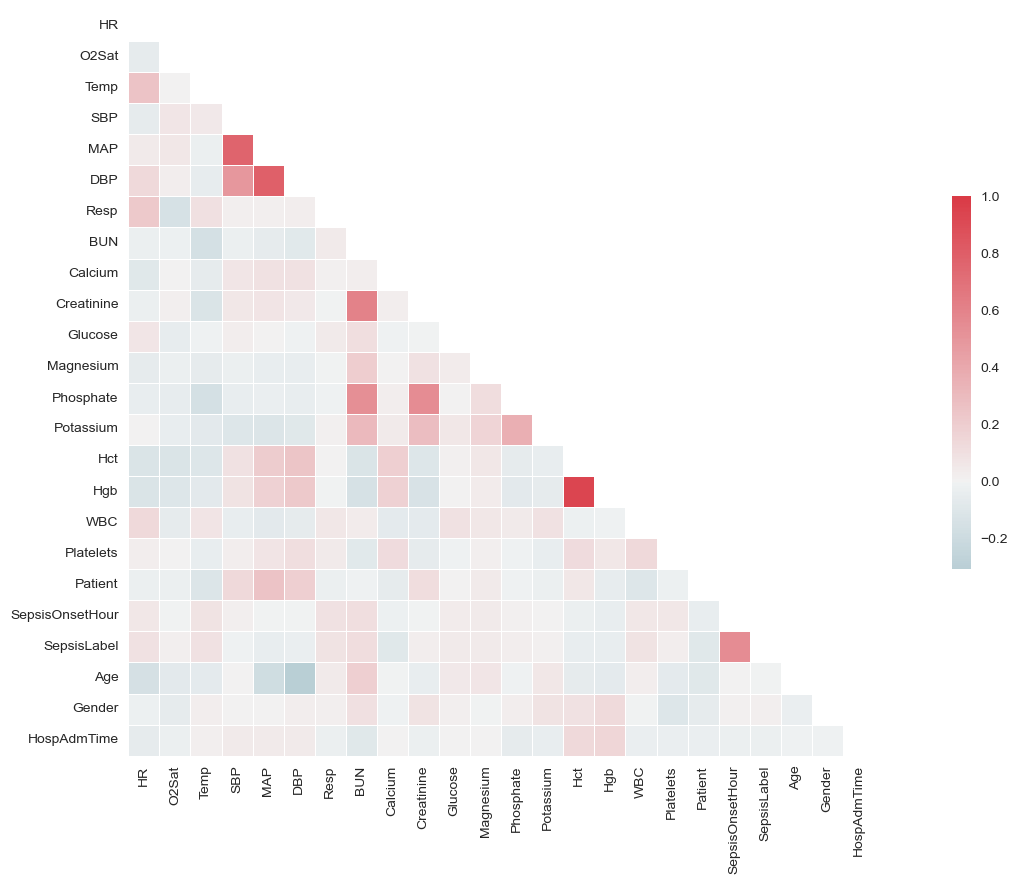

In [95]:
#look at feature correlations
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#make the heatmap plot
plt.figure(figsize=(16,9))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.tight_layout()
#plt.savefig('plots/heatmap.png', dpi=250)
plt.show()

# Resampling the highly imbalanced dataset

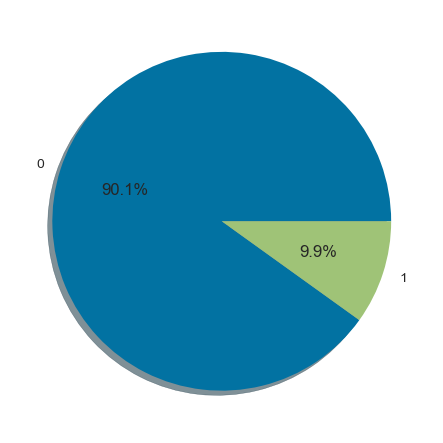

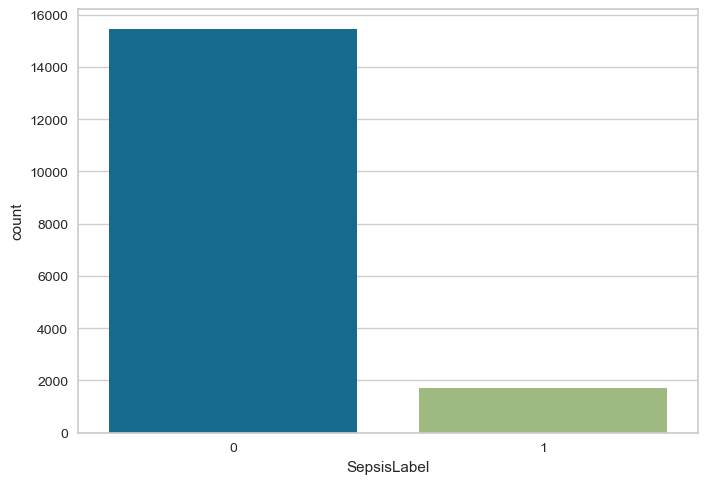

In [96]:
plt.pie(df['SepsisLabel'].value_counts(), labels=['0','1'], autopct='%1.1f%%', shadow=True)
plt.show()
sns.countplot(df['SepsisLabel'], label="Count")
plt.show()

In [125]:
df['SepsisLabel'].value_counts()

0    15439
1     1700
Name: SepsisLabel, dtype: int64

In [126]:
df_minority = df[df['SepsisLabel'] == 1]
df_majority = df[df['SepsisLabel'] == 0]

In [127]:
from sklearn.utils import resample

In [128]:
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=6000,    # to match majority class
                                 random_state=123) # reproducible results

In [129]:
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [130]:
df_upsampled.SepsisLabel.value_counts()

0    15439
1     6000
Name: SepsisLabel, dtype: int64

In [131]:
df.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'BUN', 'Calcium',
       'Creatinine', 'Glucose', 'Magnesium', 'Phosphate', 'Potassium', 'Hct',
       'Hgb', 'WBC', 'Platelets', 'Patient', 'SepsisOnsetHour', 'SepsisLabel',
       'Age', 'Gender', 'HospAdmTime'],
      dtype='object')

In [132]:
#X = df_upsampled[df_upsampled.drop(columns = ['Sepsis_predict'])].values
#Y = df_upsampled[df_upsampled['Sepsis_predict']].values
X = df_upsampled.drop(columns = ['SepsisLabel'])
Y = df_upsampled['SepsisLabel']

#get the train and test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=0)

# EDA using DABL ( Data Analysis Baseline Library )

In [133]:
import dabl

In [134]:
default_clean = dabl.clean(df, verbose = 1)
df_datatypes = dabl.detect_types(default_clean)
default_clean = dabl.clean(df, verbose = 1)
print(df_datatypes['categorical'])
print(df_datatypes['continuous'])

Detected feature types:
continuous      22
dirty_float      0
low_card_int     0
categorical      2
date             0
free_string      0
useless          0
dtype: int64
Detected feature types:
continuous      22
dirty_float      0
low_card_int     0
categorical      2
date             0
free_string      0
useless          0
dtype: int64
HR                 False
O2Sat              False
Temp               False
SBP                False
MAP                False
DBP                False
Resp               False
BUN                False
Calcium            False
Creatinine         False
Glucose            False
Magnesium          False
Phosphate          False
Potassium          False
Hct                False
Hgb                False
WBC                False
Platelets          False
Patient            False
SepsisOnsetHour    False
SepsisLabel         True
Age                False
Gender              True
HospAdmTime        False
Name: categorical, dtype: bool
HR                  True
O2Sa

Target looks like classification
Showing only top 10 of 22 continuous features
Linear Discriminant Analysis training set score: 0.704


[[<Figure size 2000x400 with 10 Axes>,
  <Figure size 1600x400 with 4 Axes>,
  <Figure size 1600x400 with 4 Axes>,
  <Figure size 800x550 with 1 Axes>],
 None]

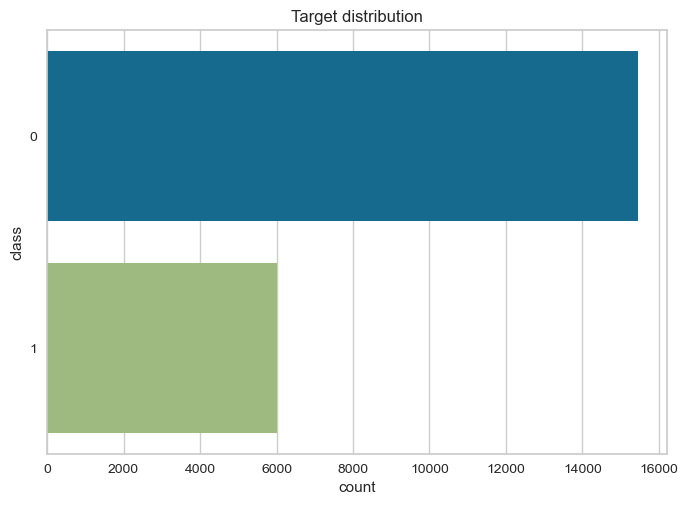

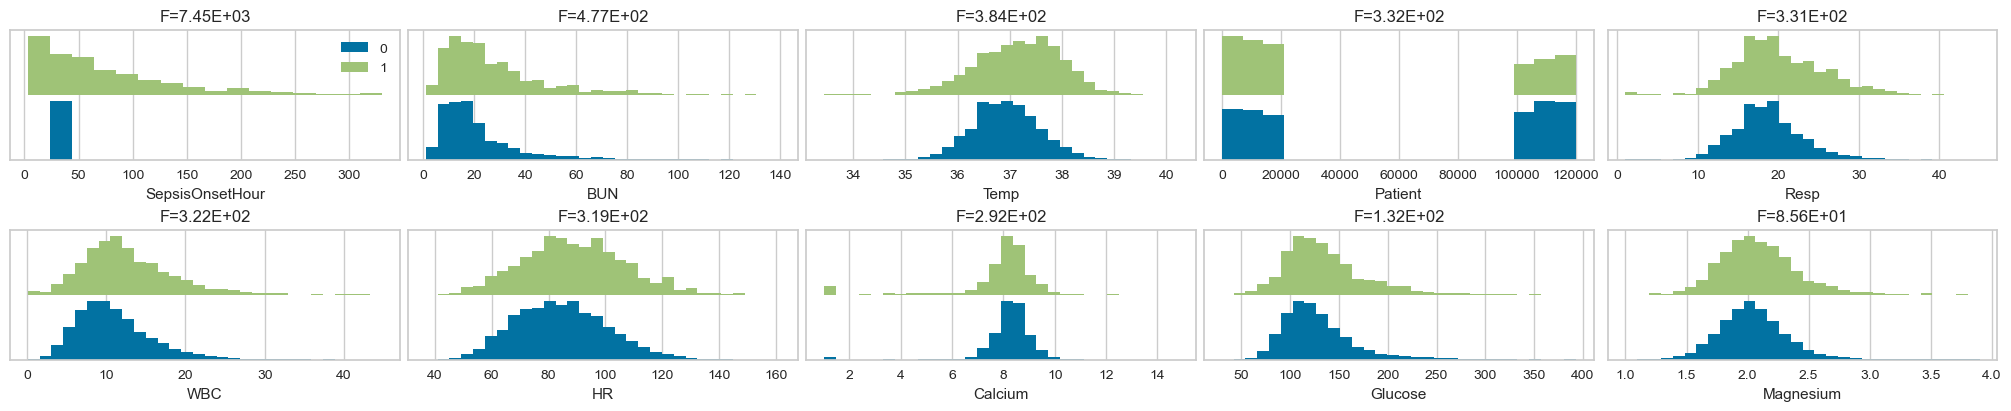

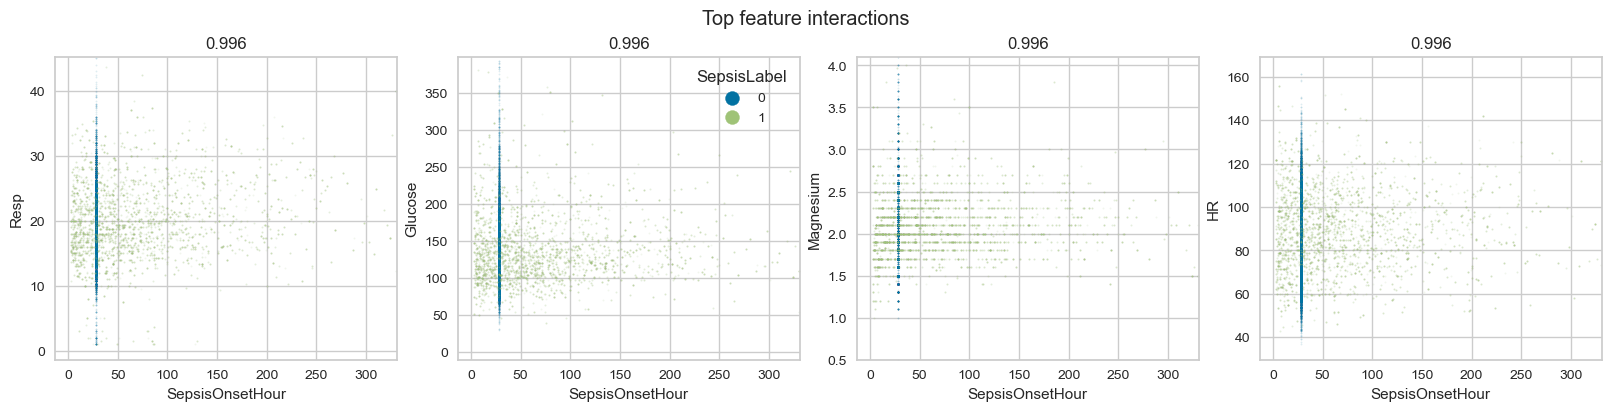

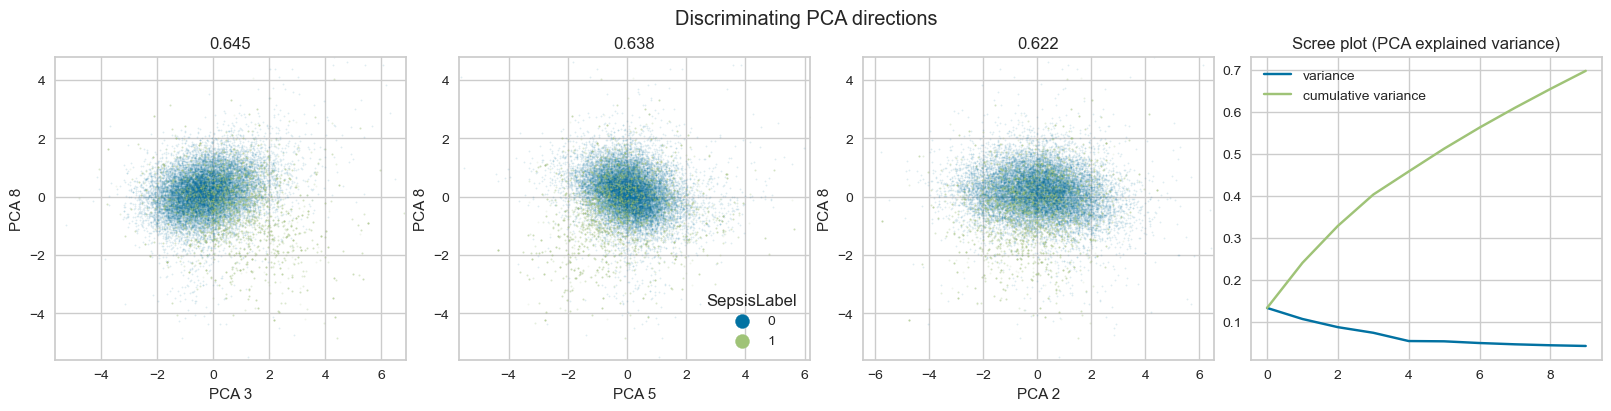

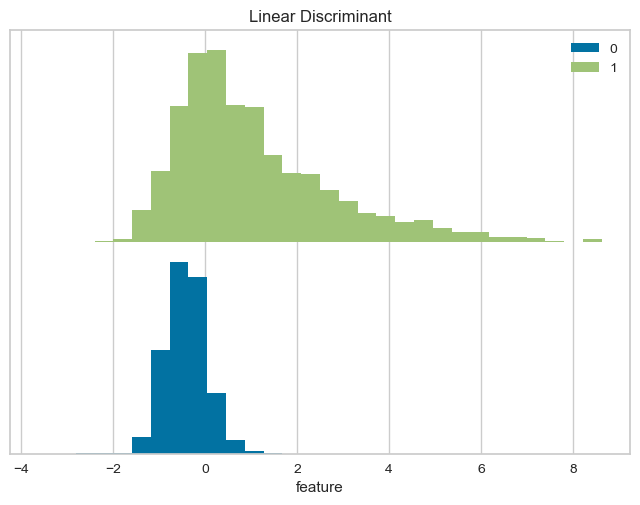

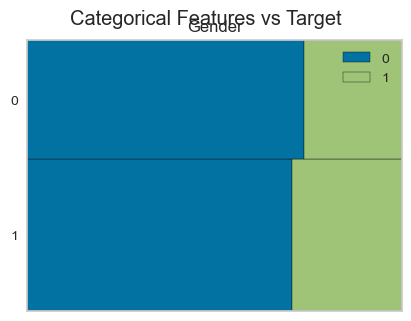

In [135]:
dabl.plot(df_upsampled, 'SepsisLabel') #only use the Target distributions AND top interaction variables charts

# Pipeline model

Read up how to interpret these plots and how to acutally relate it back to the project objectives.

In [148]:
df_upsampled = df_upsampled.drop(columns = ['SepsisOnsetHour', 'Patient'])

In [149]:
ec = dabl.SimpleClassifier().fit(df_upsampled.reset_index(drop=True), target_col = 'SepsisLabel') #unable to run this

Running DummyClassifier()
accuracy: 0.720 average_precision: 0.280 roc_auc: 0.500 recall_macro: 0.500 f1_macro: 0.419
=== new best DummyClassifier() (using recall_macro):
accuracy: 0.720 average_precision: 0.280 roc_auc: 0.500 recall_macro: 0.500 f1_macro: 0.419

Running GaussianNB()
accuracy: 0.721 average_precision: 0.444 roc_auc: 0.698 recall_macro: 0.594 f1_macro: 0.600
=== new best GaussianNB() (using recall_macro):
accuracy: 0.721 average_precision: 0.444 roc_auc: 0.698 recall_macro: 0.594 f1_macro: 0.600

Running MultinomialNB()
accuracy: 0.720 average_precision: 0.366 roc_auc: 0.595 recall_macro: 0.500 f1_macro: 0.419
Running DecisionTreeClassifier(class_weight='balanced', max_depth=1)
accuracy: 0.696 average_precision: 0.342 roc_auc: 0.596 recall_macro: 0.596 f1_macro: 0.600
=== new best DecisionTreeClassifier(class_weight='balanced', max_depth=1) (using recall_macro):
accuracy: 0.696 average_precision: 0.342 roc_auc: 0.596 recall_macro: 0.596 f1_macro: 0.600

Running Decision

Depth: 5
Number of leaves: 32


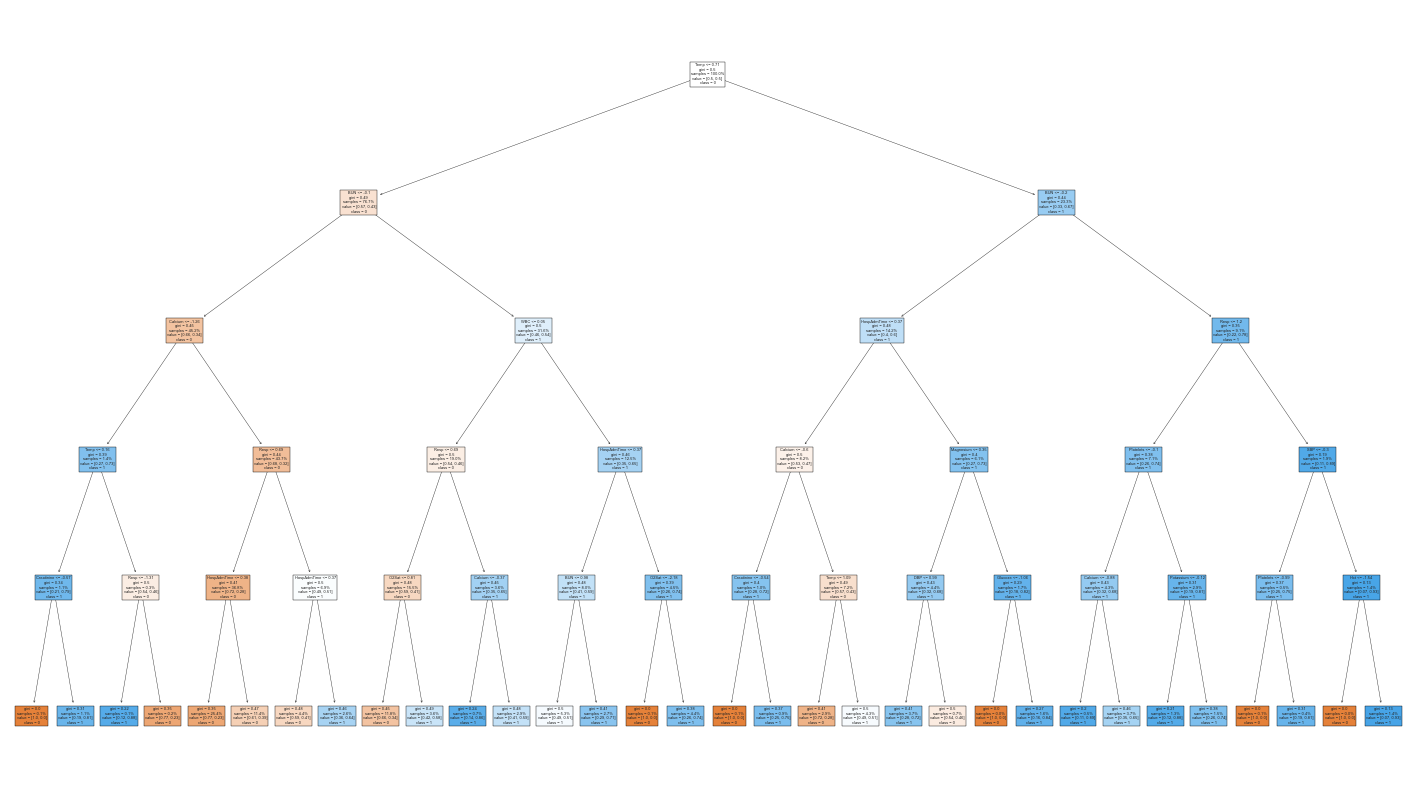

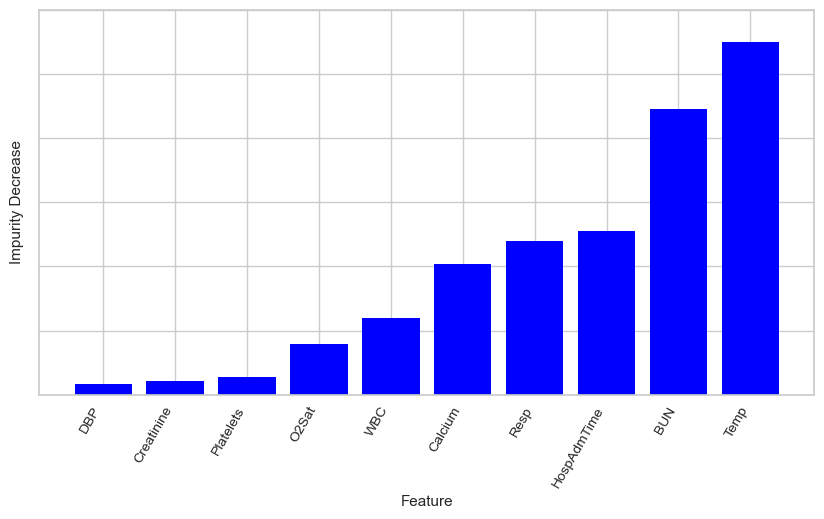

In [150]:
dabl.explain(ec)

# Modeling using Pycaret

In [158]:
df_upsampled

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BUN,Calcium,Creatinine,...,Phosphate,Potassium,Hct,Hgb,WBC,Platelets,SepsisLabel,Age,Gender,HospAdmTime
2,78.500000,95.500000,37.670000,143.166667,83.166667,55.833333,23.000000,25.000000,11.0,0.80,...,2.900000,3.400000,29.400000,11.0,8.7,486.000000,0,45.82,0,-1195.71
3,109.666667,98.666667,36.720000,117.333333,66.670000,51.500000,19.333333,19.000000,8.2,0.80,...,3.800000,4.300000,24.000000,8.3,7.6,144.000000,0,65.71,0,-8.77
6,119.000000,95.000000,38.060000,106.000000,74.000000,59.666667,21.166667,60.666667,7.5,3.80,...,2.666667,3.566667,39.033333,14.5,8.8,45.666667,0,64.24,1,-0.05
7,74.333333,98.666667,35.670000,113.333333,66.666667,47.333333,15.666667,31.000000,8.2,1.10,...,2.700000,3.200000,25.000000,8.6,9.4,205.000000,0,87.08,1,-2.23
16,96.000000,95.000000,38.386667,139.666667,91.333333,62.333333,23.333333,8.000000,7.4,0.40,...,2.100000,3.900000,27.133333,9.2,16.4,218.000000,0,87.80,0,-122.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634,66.333333,99.000000,37.220000,145.166667,80.666667,60.000000,13.500000,29.000000,8.4,0.40,...,3.400000,4.600000,35.500000,11.9,21.3,306.000000,1,79.67,0,-0.03
404,84.166667,97.166667,38.170000,113.833333,74.166667,54.833333,16.250000,27.000000,8.0,1.60,...,3.300000,4.600000,26.100000,8.8,9.1,231.000000,1,76.54,1,-0.02
1010,55.000000,99.333333,36.560000,130.000000,113.666667,72.666667,24.666667,20.000000,8.3,0.70,...,4.400000,3.900000,25.900000,8.5,10.7,320.000000,1,74.84,1,-152.21
2106,68.333333,96.666667,37.100000,93.666667,66.000000,51.666667,16.666667,7.000000,9.4,0.95,...,4.500000,3.900000,38.400000,12.6,5.2,258.000000,1,21.00,1,-0.05


In [152]:
s = setup(df_upsampled, target = 'SepsisLabel')

,Description,Value
0,Session id,1949
1,Target,SepsisLabel
2,Target type,Binary
3,Original data shape,"(47229, 22)"
4,Transformed data shape,"(47229, 22)"
5,Transformed train set shape,"(33060, 22)"
6,Transformed test set shape,"(14169, 22)"
7,Numeric features,21
8,Preprocess,True
9,Imputation type,simple


In [153]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9142,0.9408,0.9662,0.9032,0.9336,0.8128,0.8165,1.7910
et,Extra Trees Classifier,0.9138,0.9276,0.9611,0.9064,0.9330,0.8125,0.8153,1.2260
dt,Decision Tree Classifier,0.8642,0.8654,0.9629,0.8423,0.8985,0.6962,0.7107,0.1920
xgboost,Extreme Gradient Boosting,0.8626,0.9221,0.9412,0.8536,0.8953,0.6967,0.7039,2.0750
lightgbm,Light Gradient Boosting Machine,0.8221,0.8901,0.9338,0.8101,0.8676,0.6005,0.6149,0.5240
knn,K Neighbors Classifier,0.8034,0.8608,0.9282,0.7925,0.8550,0.5558,0.5730,17.3870
gbc,Gradient Boosting Classifier,0.7433,0.7851,0.9060,0.7407,0.8150,0.4093,0.4321,2.9550
ada,Ada Boost Classifier,0.7045,0.7311,0.8434,0.7270,0.7809,0.3350,0.3439,0.6620
lda,Linear Discriminant Analysis,0.6508,0.6571,0.9042,0.6610,0.7637,0.1526,0.1838,0.0680
lr,Logistic Regression,0.6497,0.6438,0.9182,0.6570,0.7659,0.1404,0.1770,3.0640


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [154]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

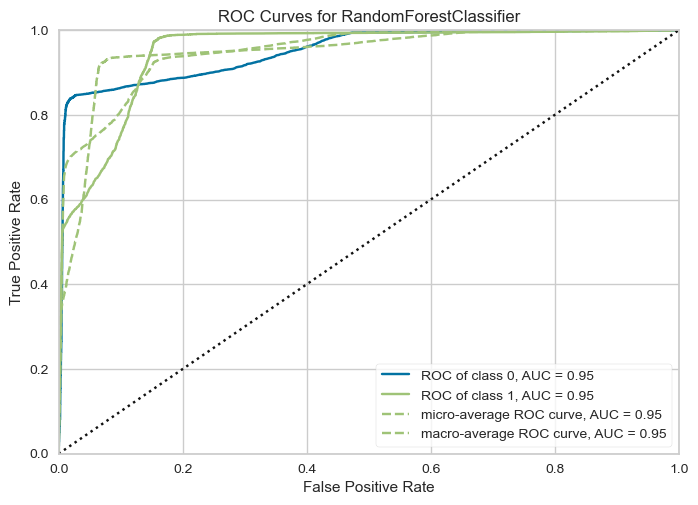

In [155]:
plot_model(best, plot = 'auc')

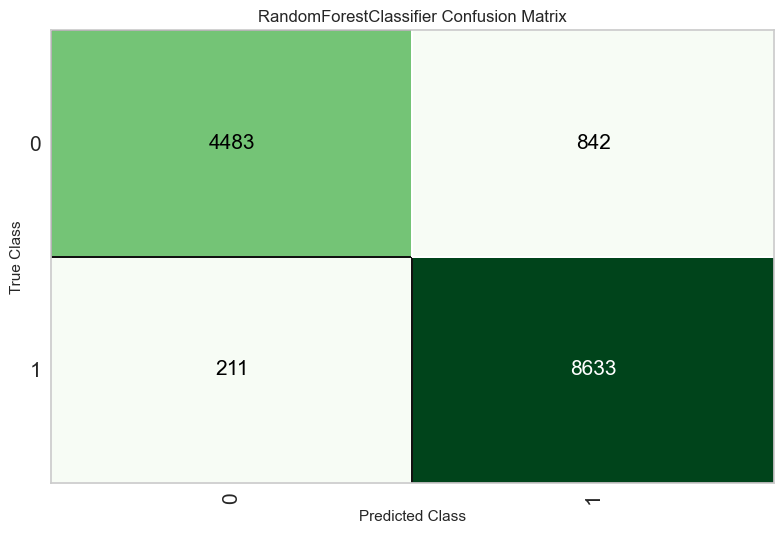

In [156]:
plot_model(best, plot = 'confusion_matrix')

In [157]:
predictions = predict_model(best, data=df, raw_score=True)
predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9236,0.9590,0.8875,0.6470,0.7484,0.7047,0.7169


,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BUN,Calcium,Creatinine,...,Hgb,WBC,Platelets,Age,Gender,HospAdmTime,SepsisLabel,prediction_label,prediction_score_0,prediction_score_1
0,116.333336,97.666664,37.793335,137.666672,105.000000,85.000000,27.0,23.0,7.6,0.7,...,10.4,14.4,759.0,27.920000,1,-0.030000,1,1,0.0000,1.0000
1,98.666664,100.000000,37.596668,144.000000,85.000000,58.333332,18.5,9.0,8.4,0.7,...,11.2,10.6,184.0,65.790001,1,-0.020000,1,1,0.0000,1.0000
2,78.500000,95.500000,37.669998,143.166672,83.166664,55.833332,23.0,25.0,11.0,0.8,...,11.0,8.7,486.0,45.820000,0,-1195.709961,0,0,0.6581,0.3419
3,109.333336,96.000000,38.240002,108.000000,79.166664,59.000000,23.0,8.0,8.1,0.4,...,8.1,11.7,701.0,39.279999,1,-0.020000,1,1,0.1160,0.8840
4,109.333336,96.000000,38.240002,108.000000,79.166664,59.000000,23.0,8.0,8.1,0.4,...,8.1,11.7,701.0,39.279999,1,-0.020000,0,1,0.1160,0.8840


In [159]:
save_model(best, 'my_best_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=C:\Users\gohch\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['HR', 'O2Sat', 'Temp', 'SBP',
                                              'MAP', 'DBP', 'Resp', 'BUN',
                                              'Calcium', 'Creatinine', 'Glucose',
                                              'Magnesium', 'Phosphate',
                                              'Potassium', 'Hct', 'Hgb', 'WBC',
                                              'Platelets', 'Age', 'Gender',
                                              'HospAdmTime'],
                                     transformer=SimpleImputer(a...
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight=None, criterion='gini',
                                         max_depth=None, max_features='auto',
               

The random forest classifier was the best traditional classifier.

# Multilayer Perceptron (MLP) model - comparison with best traditional ML models

In [241]:
#Try MLP classifier - reference https://github.com/nevermind78/Early-Prediction-of-Sepsis-From-Clinical-Data/blob/main/MLP2.ipynb

In [160]:
df_upsampled.isna().sum()
df_upsampled.dtypes

HR             float64
O2Sat          float64
Temp           float64
SBP            float64
MAP            float64
DBP            float64
Resp           float64
BUN            float64
Calcium        float64
Creatinine     float64
Glucose        float64
Magnesium      float64
Phosphate      float64
Potassium      float64
Hct            float64
Hgb            float64
WBC            float64
Platelets      float64
SepsisLabel      int64
Age            float64
Gender           int64
HospAdmTime    float64
dtype: object

In [161]:
#Train test split
X = df_upsampled.drop(columns = ['SepsisLabel'])
Y = df_upsampled['SepsisLabel']
#get the train and test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=0)

In [162]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neural_network import MLPClassifier

In [163]:
clf=MLPClassifier(
    activation='tanh',
    solver='lbfgs',
    early_stopping=False,
    hidden_layer_sizes=(40,10,10,10,10, 2),
    random_state=1,
    batch_size='auto',
    max_iter=13000,
    learning_rate_init=1e-5,
    tol=1e-4,)

In [164]:
clf.fit(X_train, Y_train)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(40, 10, 10, 10, 10, 2),
              learning_rate='constant', learning_rate_init=1e-05, max_fun=15000,
              max_iter=13000, momentum=0.9, n_iter_no_change=10,
              nesterovs_momentum=True, power_t=0.5, random_state=1,
              shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
              verbose=False, warm_start=False)

In [165]:
import pickle

In [166]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)
     

FileNotFoundError: [Errno 2] No such file or directory: 'finalized_model2.sav'

In [ ]:
from sklearn.metrics import confusion_matrix ,ConfusionMatrixDisplay

In [ ]:
predicted = loaded_model.predict(X_test)
print(predicted.shape)
print(Y_test.shape)
print(confusion_matrix(Y_test,predicted))

In [ ]:
cm=confusion_matrix(Y_test,predicted)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

In [ ]:
def plot_ROC(y_test, y_score, n_classes=2):
    from sklearn.metrics import precision_score, classification_report,average_precision_score, accuracy_score, balanced_accuracy_score, precision_recall_curve, f1_score, auc, roc_curve
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr['positive'], tpr['positive'], _ = roc_curve(y_test, y_score)
    roc_auc['positive'] = auc(fpr['positive'], tpr['positive'])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.figure()
    lw = 2
    plt.plot(fpr['positive'], tpr['positive'], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc['positive'])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
plot_ROC(Y_test,yhat_probas[:,1])

In [ ]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import shap

shap.initjs()
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)
# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)
# create a simple model
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True
}
model = lgb.train(params, d_train, 10000, valid_sets=[d_test], early_stopping_rounds=50, verbose_eval=1000)
# explain the model
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
# visualize the impact of each features
shap.summary_plot(shap_values, X)

# More things to try
- SHAP or LIME for explainable Machine Learning
- to engineer new variables like try the delta 
- remember to do train/test split before doing auto ML! and find a accuracy score for the test
- 
- Try different window timings, will t=6 or 10 for window give fewer null values 